## IMPORT LIBRARIES AND LOAD DATASET

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, roc_curve, auc

In [ ]:
raw_df = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')

## RETRIVE DATASET INFORMATION

In [ ]:
# Dataset Shape

raw_df.shape

(5110, 12)

In [ ]:
# Column names and types

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Head or Tail of the Dataset

raw_df.head(5)
#raw_df.tail(5)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [ ]:
# Statistics information

raw_df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [ ]:
# Find Duplicates

id_feature = 'id'
print(f'Shape: {raw_df.shape}\nTotal ID: {raw_df.nunique()[id_feature]}')

duplicate_rows_df = raw_df[raw_df.duplicated()]
print("Number of duplicated rows:", duplicate_rows_df.shape[0])

Shape: (5110, 12)
Total ID: 5110
Number of duplicated rows: 0


In [ ]:
# Revise and Count unique values

# Remove continuous features, id and age
columns = raw_df.columns
columns=columns.drop(['id', 'age', 'avg_glucose_level', 'bmi'])
#columns

for column in columns:
    #print(raw_df.loc[:,column].unique())
    print(raw_df.loc[:,column].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
hypertension
0    4612
1     498
Name: count, dtype: int64
heart_disease
0    4834
1     276
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
stroke
0    4861
1     249
Name: count, dtype: int64


In [ ]:
# First Analysis about patients to drop:
    # "Others" in gender because it has just one istance
    # "Unkown" is a category in smoking_status that has 1544 istances, we have two options:
        # As you can see below, those are almost all patients without stroke (stroke = 0)
        # Drop everyone because it's a tricky value, but we would loose a lot of information
        # Continue as normal and we compare the results from these two options.

for column in columns:
    if column != 'smoking_status':
        print(f"Values in column:{column}")
        print(raw_df[raw_df['smoking_status'] == "Unknown"].loc[:,column].value_counts())

Values in column:gender
gender
Female    836
Male      708
Name: count, dtype: int64
Values in column:hypertension
hypertension
0    1492
1      52
Name: count, dtype: int64
Values in column:heart_disease
heart_disease
0    1496
1      48
Name: count, dtype: int64
Values in column:ever_married
ever_married
No     901
Yes    643
Name: count, dtype: int64
Values in column:work_type
work_type
Private          640
children         618
Self-employed    156
Govt_job         122
Never_worked       8
Name: count, dtype: int64
Values in column:Residence_type
Residence_type
Urban    782
Rural    762
Name: count, dtype: int64
Values in column:stroke
stroke
0    1497
1      47
Name: count, dtype: int64


## MANAGE NAN VALUES

In [ ]:
raw_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# Finding the null values for BMI

print(raw_df[raw_df['bmi'].isna()].loc[:,"stroke"].value_counts())

stroke
0    161
1     40
Name: count, dtype: int64


In [ ]:
# Calculating the correlation of BMI with other features to specifically check if 'BMI' has a high correlation with another feature

numerical_columns = raw_df.drop('stroke', axis=1).select_dtypes(exclude='object').columns

corr_matrix = raw_df[numerical_columns].corr()
corr_matrix

id       age  hypertension  heart_disease  \
id                 1.000000  0.003538      0.003550      -0.001296   
age                0.003538  1.000000      0.276398       0.263796   
hypertension       0.003550  0.276398      1.000000       0.108306   
heart_disease     -0.001296  0.263796      0.108306       1.000000   
avg_glucose_level  0.001092  0.238171      0.174474       0.161857   
bmi                0.003084  0.333398      0.167811       0.041357   

                   avg_glucose_level       bmi  
id                          0.001092  0.003084  
age                         0.238171  0.333398  
hypertension                0.174474  0.167811  
heart_disease               0.161857  0.041357  
avg_glucose_level           1.000000  0.175502  
bmi                         0.175502  1.000000

Text(0, 0.5, 'Age')

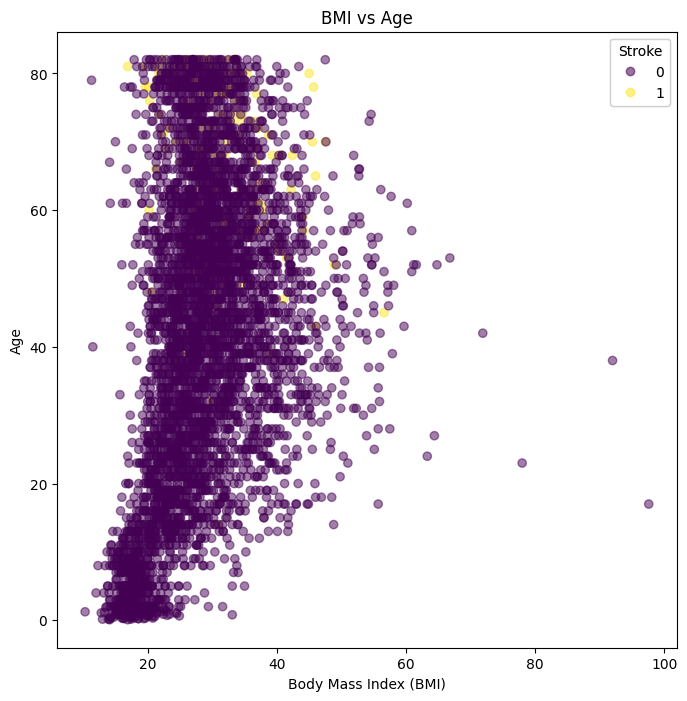

In [ ]:
# Visulazing the scatter plot for BMI vs Age since they have the highest correlation

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(raw_df.dropna()['bmi'], raw_df.dropna()['age'], c=raw_df.dropna()['stroke'], cmap='viridis', alpha=0.5)

legend1 = ax.legend(*scatter.legend_elements(), title='Stroke')
ax.add_artist(legend1)

ax.set_title('BMI vs Age')
ax.set_xlabel('Body Mass Index (BMI)')
ax.set_ylabel('Age')

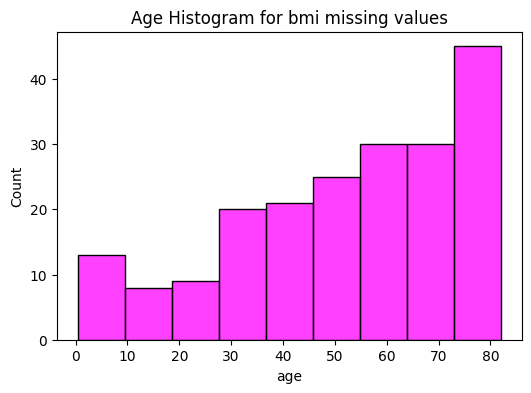

In [ ]:
# Age values histogram for the bmi missing data:

plt.figure(figsize=(6,4))

sns.histplot(raw_df[raw_df['bmi'].isna()].loc[:,"age"], color='magenta')

plt.title('Age Histogram for bmi missing values')
plt.show()

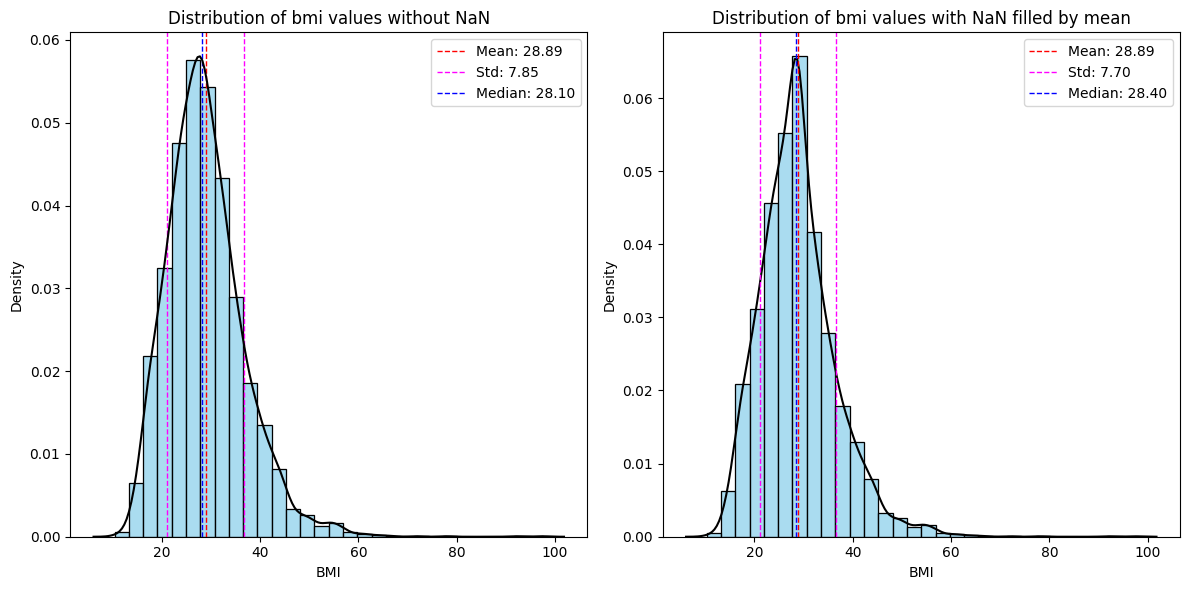

In [ ]:
# NaN are all in bmi feature, before decide the filling method I need to visualize these vales

feature_to_viz = "bmi"

# Calculate statistics about this feature without NaN
feature_values_no_NaN = raw_df[feature_to_viz].dropna()
mean = feature_values_no_NaN.mean()
std = feature_values_no_NaN.std()
median = feature_values_no_NaN.median()

# Plot distribution side by side without NaN values and filled with mean or median value
plt.figure(figsize=(12,6))

# Without NaN values
plt.subplot(1,2,1)

# Add vertical lines for mean, std, and median
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
plt.axvline(mean + std, color='magenta', linestyle='dashed', linewidth=1, label=f'Std: {std:.2f}')
plt.axvline(mean - std, color='magenta', linestyle='dashed', linewidth=1)
plt.axvline(median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')

plt.legend()

sns.histplot(feature_values_no_NaN, bins = 30, color='skyblue', alpha=0.7, stat="density")
sns.kdeplot(feature_values_no_NaN, color='black')
plt.title("Distribution of bmi values without NaN")
plt.xlabel("BMI")
plt.ylabel('Density')

# Plot with NaN values filled with mean value (same analysis could be done with median)
filled_NaN = raw_df.copy()
filled_NaN[feature_to_viz].fillna(mean, inplace=True)
plt.subplot(1,2,2)

sns.histplot(filled_NaN[feature_to_viz], bins=30, color='skyblue', alpha=0.7, stat='density')
sns.kdeplot(filled_NaN[feature_to_viz], color='black')
plt.axvline(filled_NaN[feature_to_viz].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {filled_NaN[feature_to_viz].mean():.2f}')
plt.axvline(filled_NaN[feature_to_viz].mean() + filled_NaN[feature_to_viz].std(), color='magenta', linestyle='dashed', linewidth=1, label=f'Std: {filled_NaN[feature_to_viz].std():.2f}')
plt.axvline(filled_NaN[feature_to_viz].mean() - filled_NaN[feature_to_viz].std(), color='magenta', linestyle='dashed', linewidth=1)
plt.axvline(filled_NaN[feature_to_viz].median(), color='blue', linestyle='dashed', linewidth=1, label=f'Median: {filled_NaN[feature_to_viz].median():.2f}')

plt.legend()

plt.title("Distribution of bmi values with NaN filled by mean")
plt.xlabel("BMI")
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
#After analyzing correlation and visualization collectively, it's evident that there's a low correlation between BMI and other features, suggesting that the missing BMI values are random in nature.
#The decision to use KNN imputation was made because it's effective for dealing with data missing at random (MCAR) or missing at random (MAR) patterns.
#We decided against interpolating or predicting BMI values based on other features due to the arbitrary nature of such methods and the risk of information loss.
#The chosen approach involves finding the best K value that minimizes RMSE after a random forest regression, ensuring an optimal imputation strategy.
#Once the optimal K value is determined, we'll use KNN imputation to fill NaN values in the BMI feature, maintaining data integrity and distribution.
# Create a copy of raw_df
df_impute = raw_df.copy()
df_impute.drop('id', axis=1, inplace=True)

# Initialize LabelEncoder for categorical features
label_encoder = LabelEncoder()
categorical_columns = df_impute.select_dtypes(include='object').columns
for column in categorical_columns:
    df_impute[column] = label_encoder.fit_transform(df_impute[column])

errors = []

for K in range(1,20):
    imputer_KNN = KNNImputer(n_neighbors=K)
    imputed_data = imputer_KNN.fit_transform(df_impute)
    df_KNN_imputed = pd.DataFrame(imputed_data, columns=df_impute.columns)

    X = df_KNN_imputed.drop('bmi', axis=1)
    y = df_KNN_imputed['bmi']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

    model_RF = RandomForestRegressor()
    model_RF.fit(X_train,y_train)
    predictions = model_RF.predict(X_test)
    rms_error = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'For K = {K}, RMSE = {rms_error:.2f}')
    errors.append(rms_error)

print(f'Min RMSE for {errors.index(min(errors))+1}')
K_min = errors.index(min(errors))+1
imputer_KNN = KNNImputer(n_neighbors=K_min)
imputed_data = imputer_KNN.fit_transform(df_impute)
df_KNN_imputed = pd.DataFrame(imputed_data, columns=df_impute.columns)


For K = 1, RMSE = 6.89
For K = 2, RMSE = 6.79
For K = 3, RMSE = 6.76
For K = 4, RMSE = 6.74
For K = 5, RMSE = 6.74
For K = 6, RMSE = 6.78
For K = 7, RMSE = 6.74
For K = 8, RMSE = 6.77
For K = 9, RMSE = 6.74
For K = 10, RMSE = 6.75
For K = 11, RMSE = 6.76
For K = 12, RMSE = 6.76
For K = 13, RMSE = 6.76
For K = 14, RMSE = 6.77
For K = 15, RMSE = 6.77
For K = 16, RMSE = 6.74
For K = 17, RMSE = 6.74
For K = 18, RMSE = 6.77
For K = 19, RMSE = 6.77
Min RMSE for 4


In [ ]:
# Conclusion for the missing values:
    # Fill NaN values using bmi feature from KNN Impute
    # Drop Other in gender feature
    # Drop id column
    # Try both options for Unknown category in smoking_status feature: with or without

df = raw_df.copy()
#df["bmi"].fillna(df["bmi"].mean(), inplace=True)
df['bmi'] = df_KNN_imputed['bmi'].round(1).astype(float)
df.drop(df[df["gender"]=="Other"].index, inplace=True)
df.drop('id', axis=1, inplace=True)

print(f'New Shape: {df.shape}')

#df.drop(df[df['smoking_status']=='Unknown'].index, inplace=True)

New Shape: (5109, 11)


## DATA VISUALIZATION

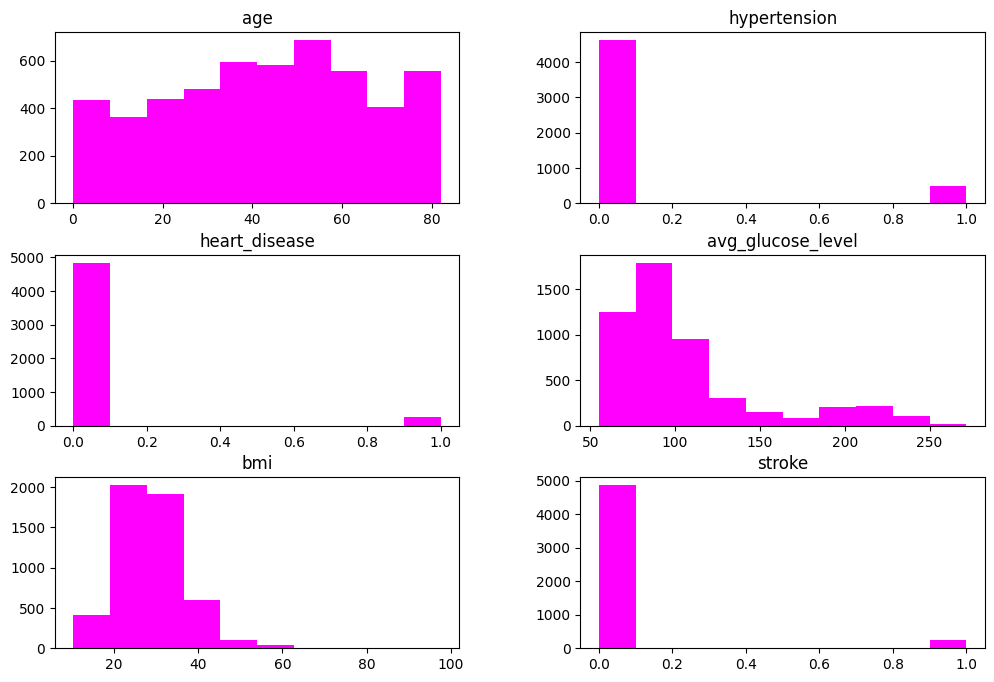

In [ ]:
#General view for some features: histograms

df.hist(figsize=(12, 8), grid=False,color='magenta')
plt.show()

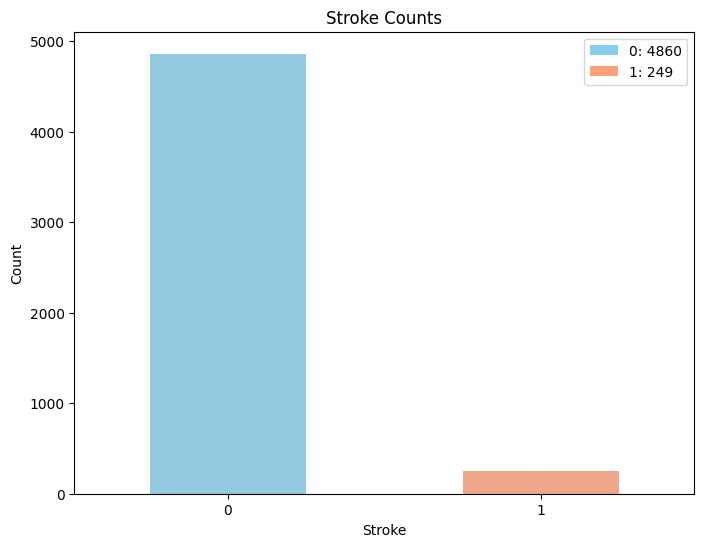

In [ ]:
# Count Plot for stroke: it is clear we have an unbalanced dataset
# This is an issue we will discuss later

# Calculate counts for each option
counts = df['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig = plt.figure(figsize=(8,6))
sns.countplot(df, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5)
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    plt.bar(i, 0, color=color, label=f'{i}: {count}')

plt.legend(loc='upper right')
plt.show()

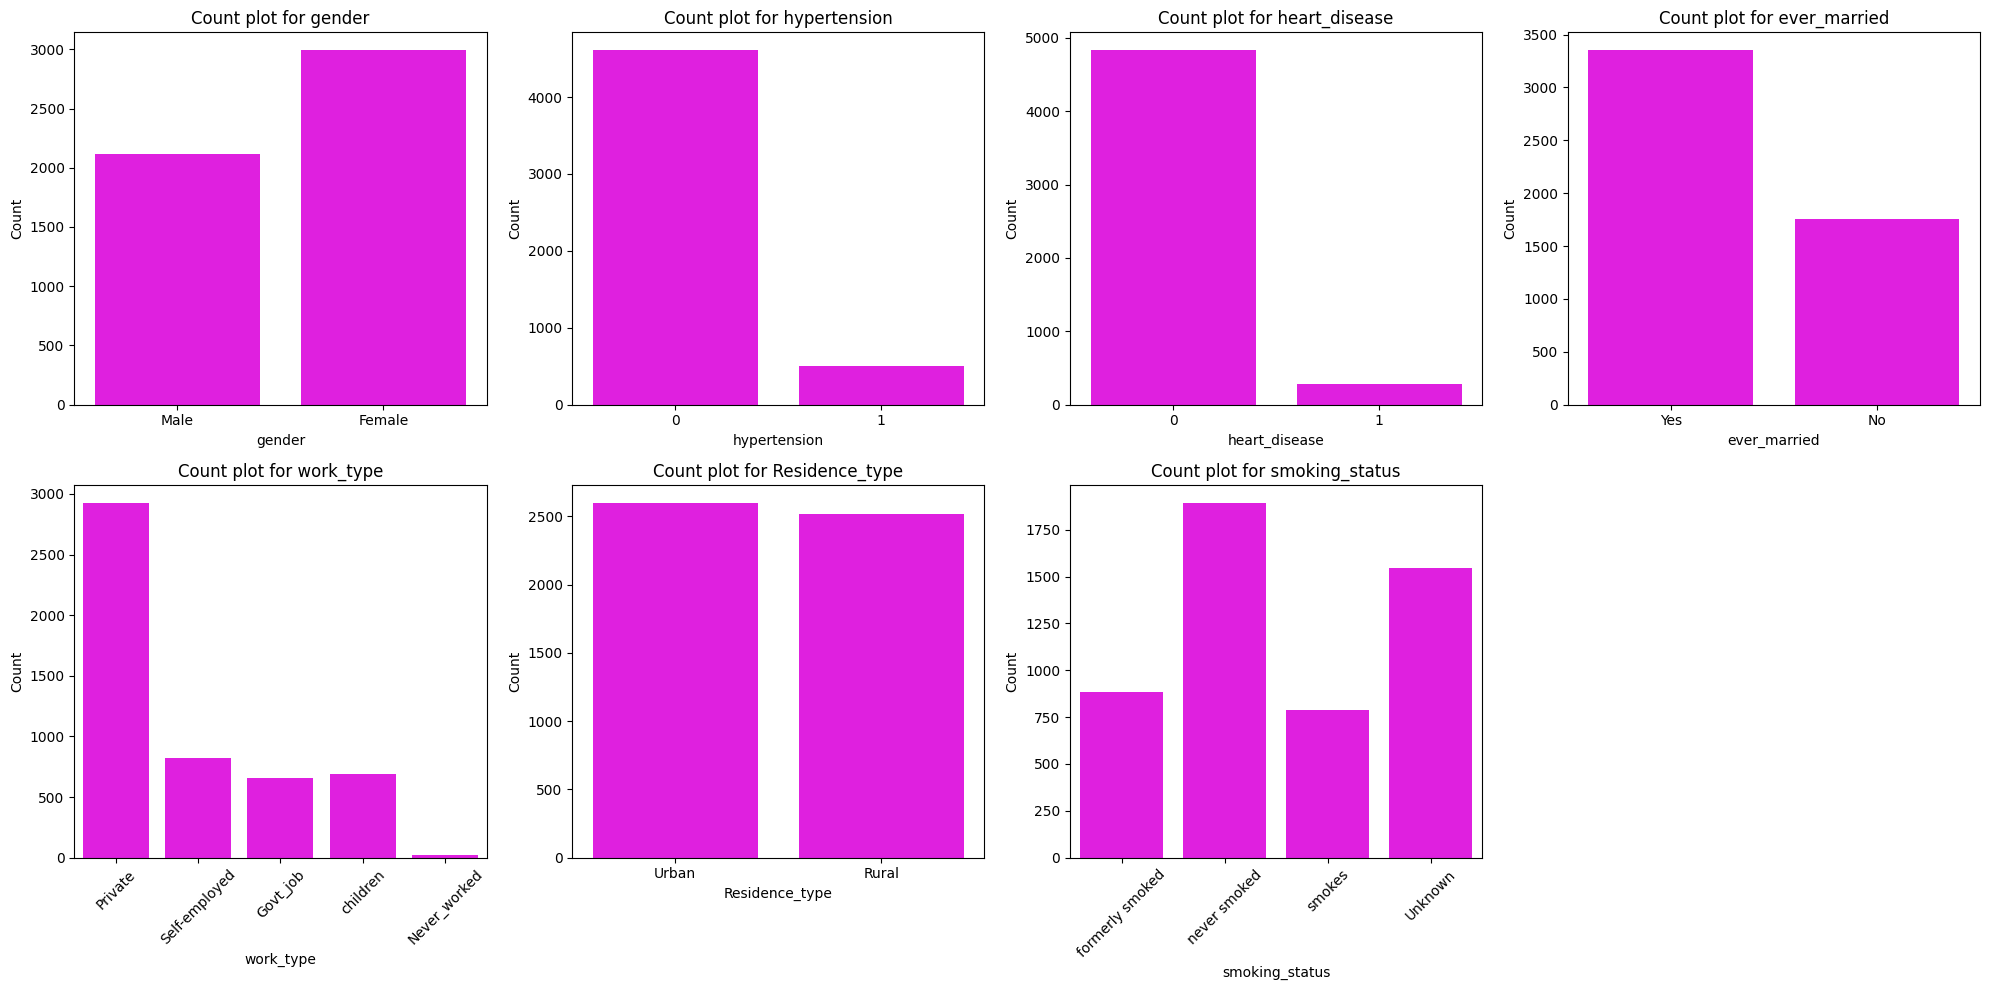

In [ ]:
# Bar plots for categorical features: excluding target feature (stroke) and including discrete features

categorical_features = df.drop('stroke', axis=1).select_dtypes(include=['object', 'int']).columns

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (len(categorical_features) + num_rows - 1) // num_rows

fig, axes = plt.subplots(num_rows,num_cols, figsize=(20,10))

axes = axes.flatten()

# Iteration for each categorical feature
for i,column in enumerate(categorical_features):
    sns.countplot(data=df, x=column, ax=axes[i],color='magenta')
    axes[i].set_title(f"Count plot for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")
    if column == "work_type" or column == "smoking_status":
        axes[i].tick_params(axis='x', rotation = 45)

# Hide any unused subplots
for j in range(len(categorical_features), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

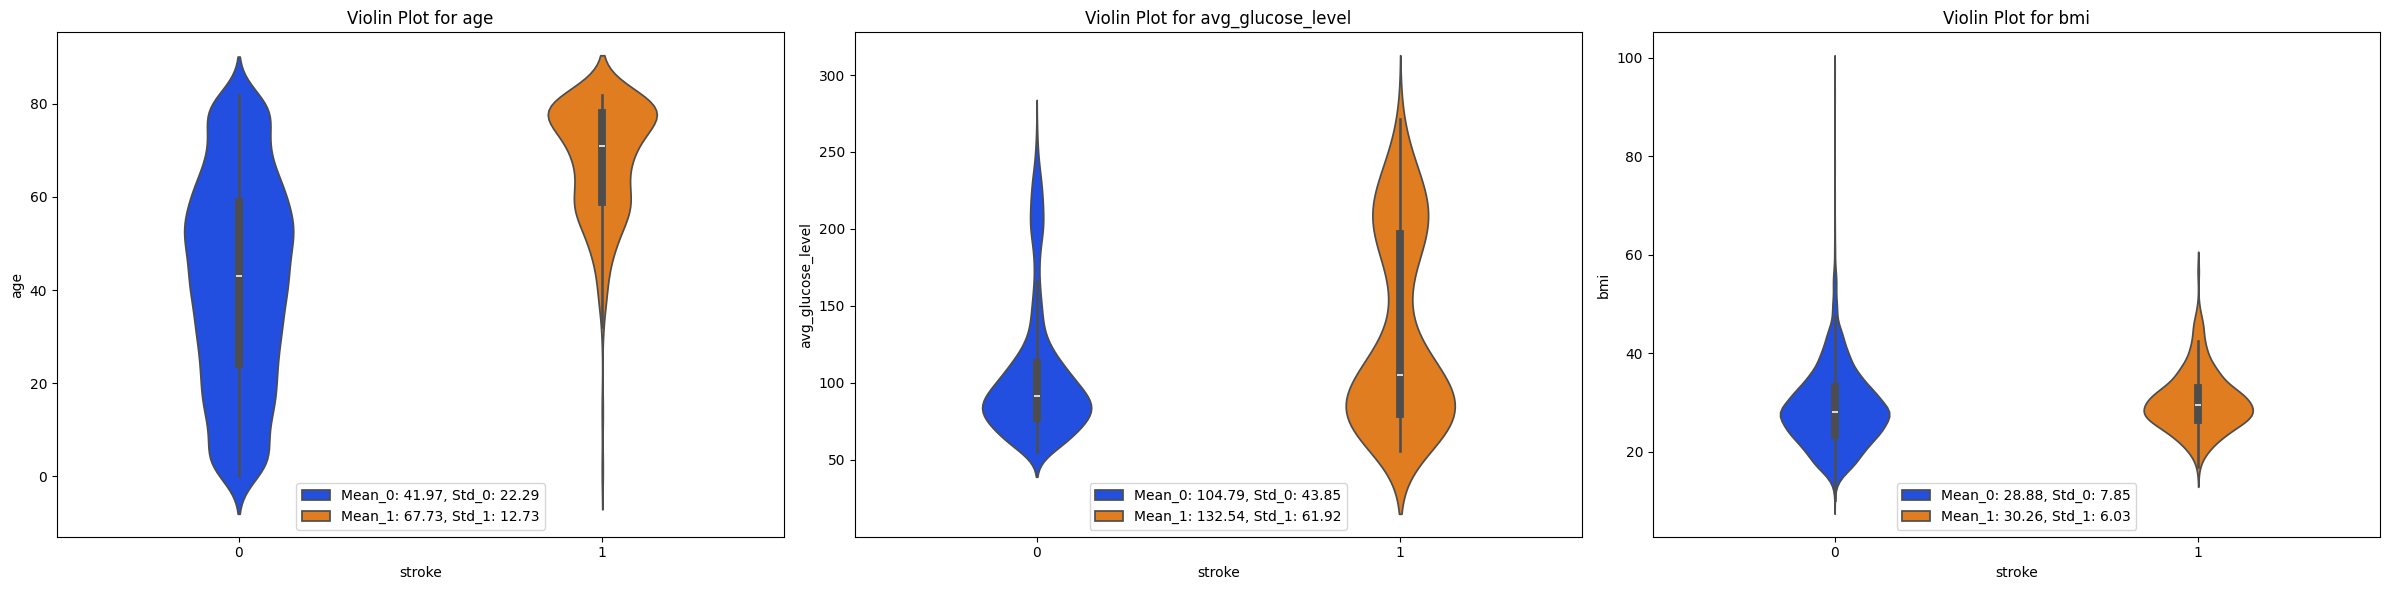

In [ ]:
# Distribution of numerical feature according to stroke using Violin Plots

# Define all the columns except stoke
numerical_columns = df.select_dtypes(exclude=['object', 'int']).columns

# Calculate the number of rows and columns for subplots
num_rows = 1
num_cols = (len(numerical_columns) + num_rows - 1) // num_rows

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24,6))

axes = axes.flatten()

# Iterate over each numerical column and plot a boxplot
for i, column in enumerate(numerical_columns):

    sns.violinplot(data=df, x='stroke', y=column, ax=axes[i], hue='stroke', palette='bright'
                , width=0.3
                )
    axes[i].set_title(f"Violin Plot for {column}")
    axes[i].set_xlabel("stroke")
    axes[i].set_ylabel(column)

    # Calculate mean and standard deviation
    mean_value = df.groupby('stroke')[column].mean()
    std_value = df.groupby('stroke')[column].std()

    # Add legend with mean and standard deviation
    legend_handles, _ = axes[i].get_legend_handles_labels()
    legend = axes[i].legend(labels=[f"Mean_0: {mean_value[0]:.2f}, Std_0: {std_value[0]:.2f}",
                                              f"Mean_1: {mean_value[1]:.2f}, Std_1: {std_value[1]:.2f}"],
                                              handles=legend_handles, loc='lower center')

plt.tight_layout()
plt.show()


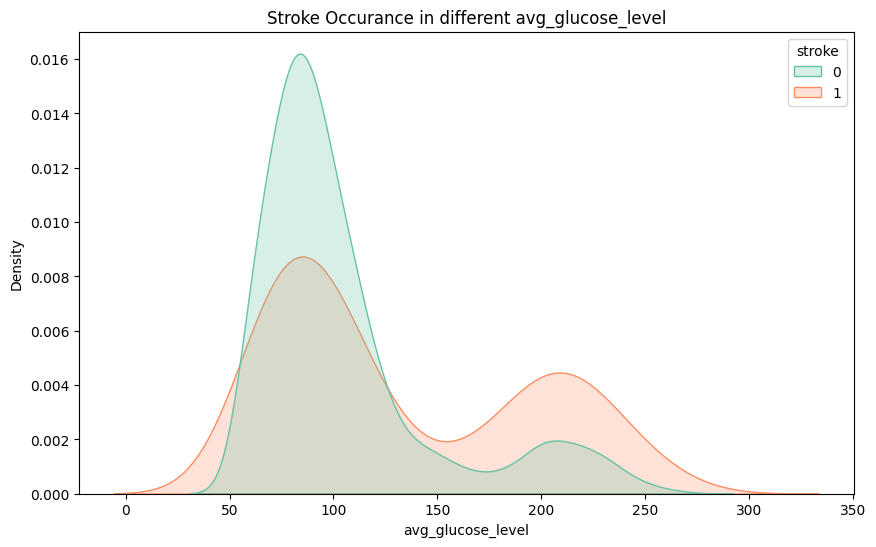

In [ ]:
# Density plot of one feature for each 'stroke' category in order to have a deeper view

# Chose your feature
feature = 'avg_glucose_level'

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x=feature, hue='stroke', fill=True, common_norm=False, palette="Set2")
plt.title(f'Stroke Occurance in different {feature}')
plt.xlabel(f'{feature}')
plt.ylabel('Density')

plt.show()

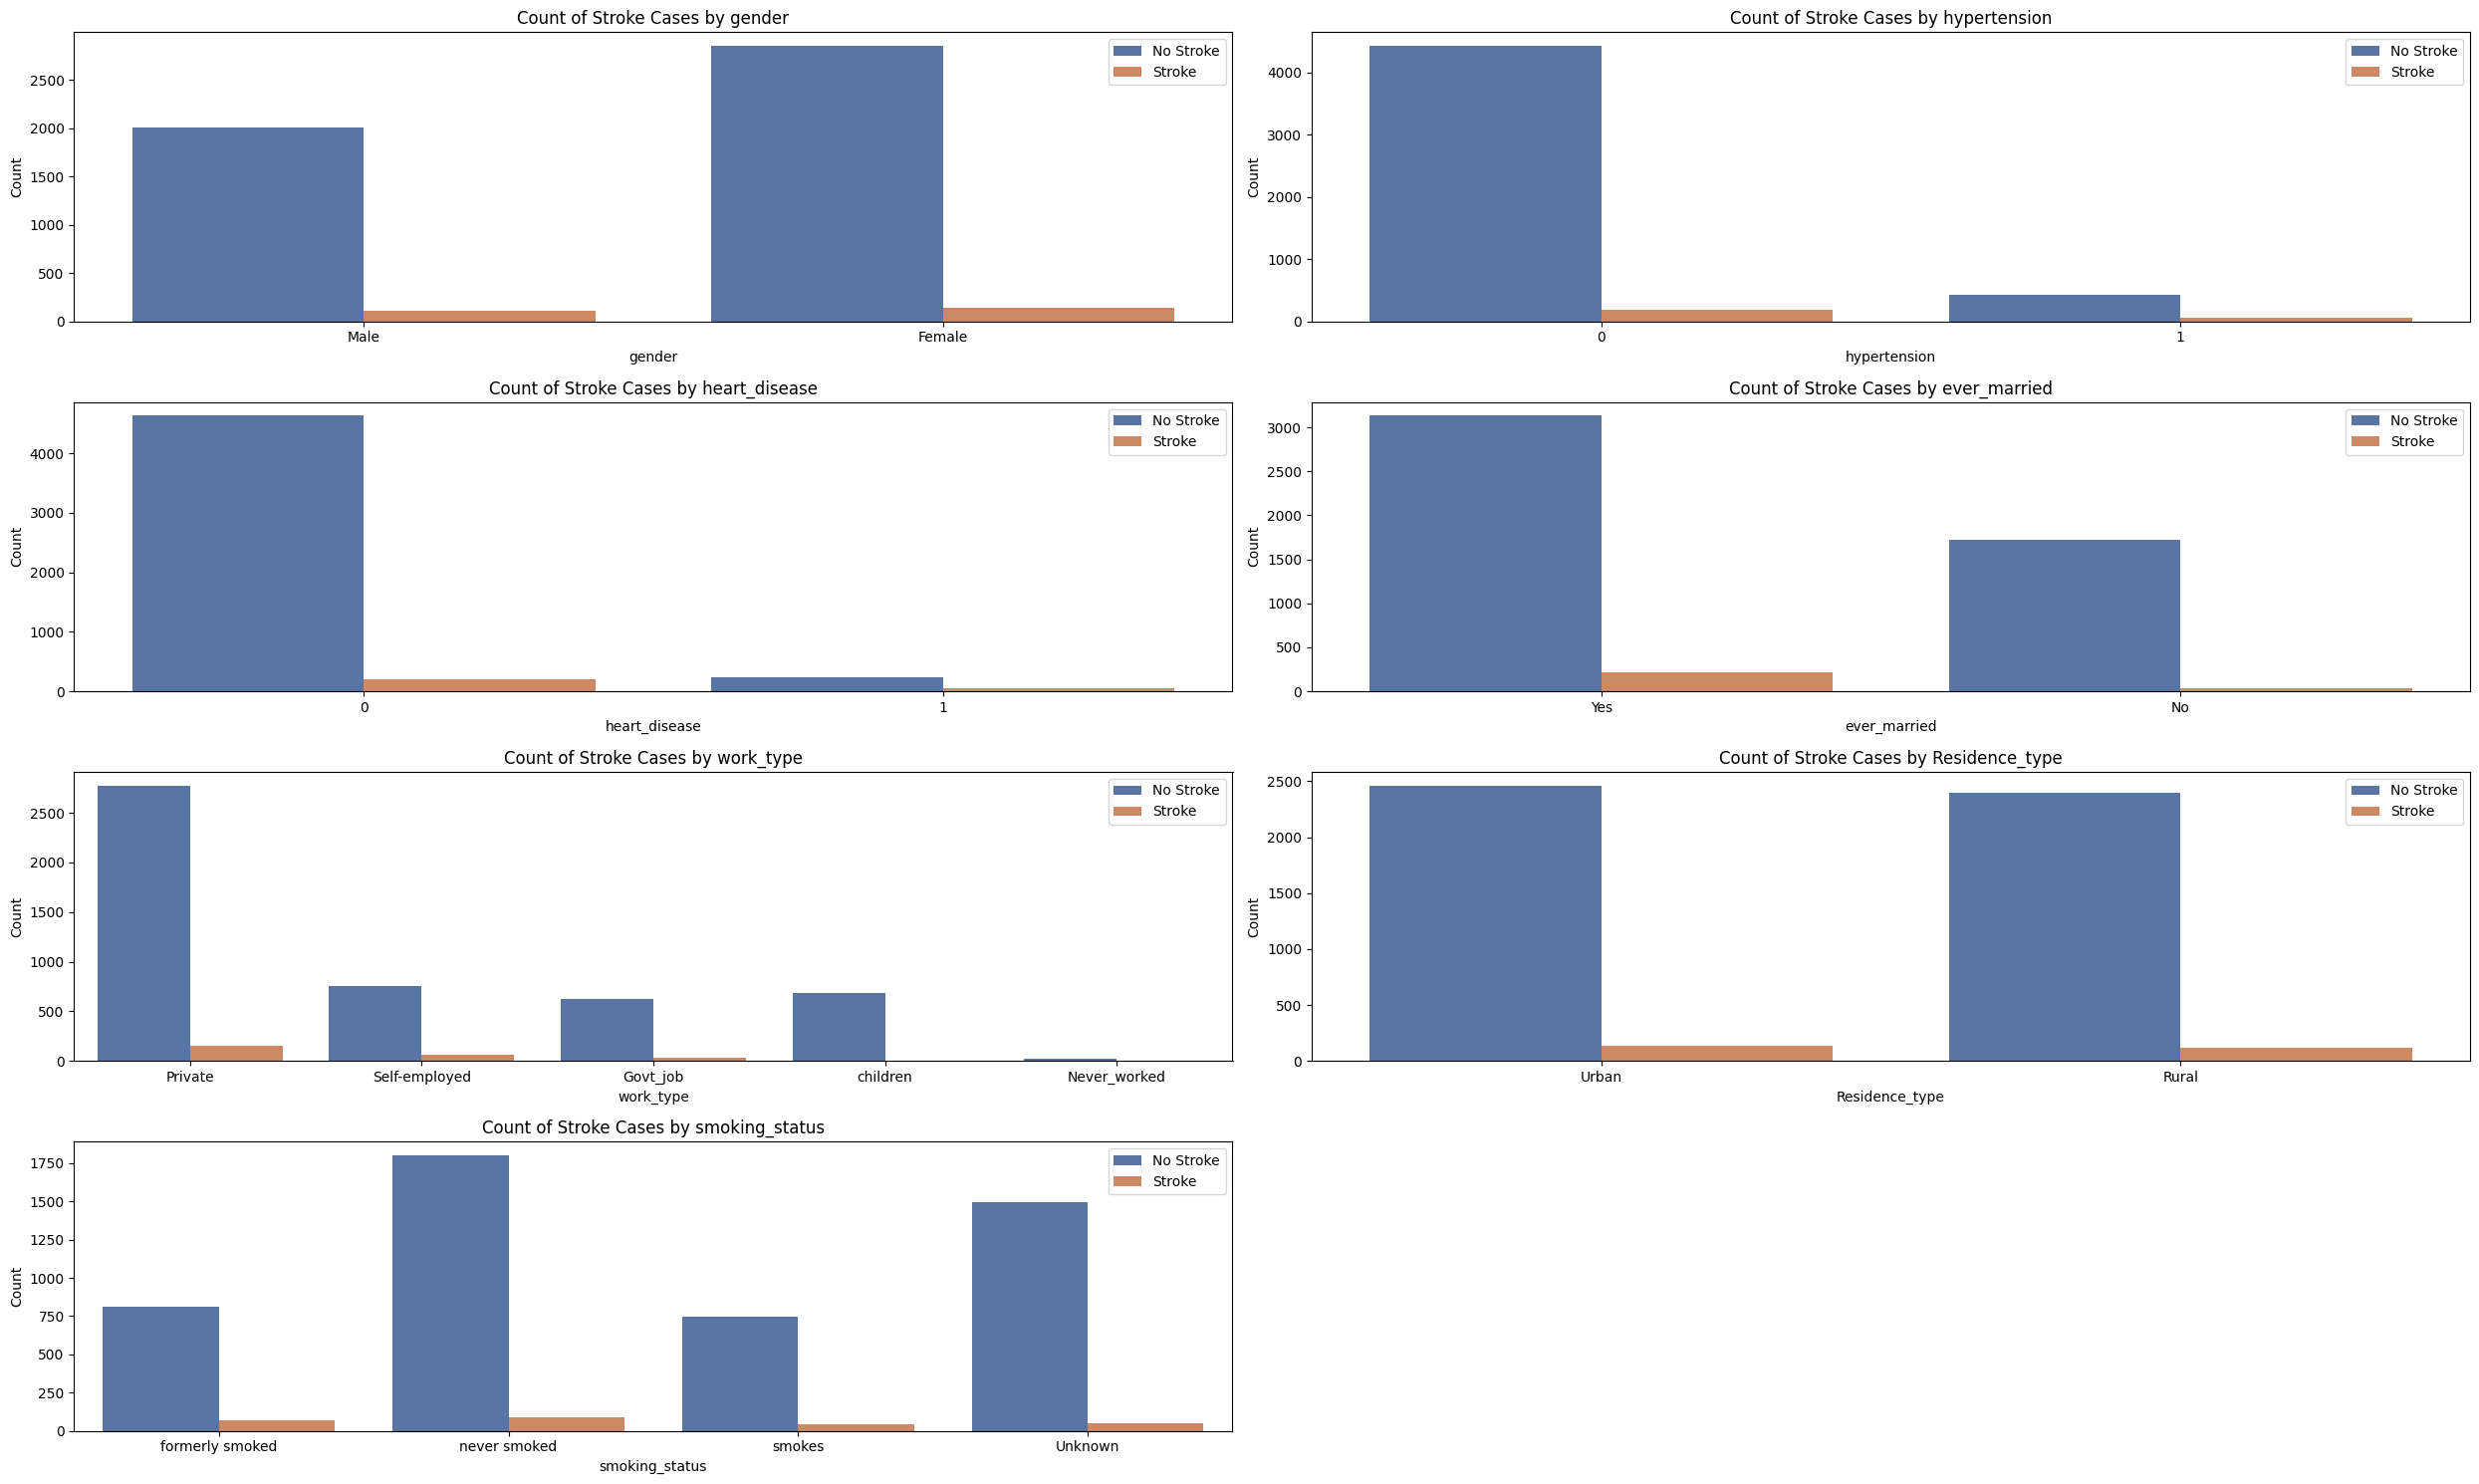

In [ ]:
# How categorical features are distributed according to stroke using Count Plots

# Define the categorical features you want to evaluate
categorical_features = df.drop("stroke", axis=1).select_dtypes(include=['object', 'int']).columns

# Calculate the number of rows and columns for subplots
num_cols = 2
num_rows = (len(categorical_features) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

axes = axes.flatten()

# Iterate over each categorical feature
for i, cat_feature in enumerate(categorical_features):
    # Create a countplot
    sns.countplot(data=df, x=cat_feature, hue='stroke', palette="deep", ax=axes[i])
    axes[i].set_title(f"Count of Stroke Cases by {cat_feature}")
    axes[i].set_xlabel(cat_feature)
    axes[i].set_ylabel("Count")
    axes[i].legend(labels=["No Stroke", "Stroke"])

# Hide any unused subplots
for j in range(len(categorical_features), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Counts Table for each categorical feature options according to stroke

# Define the categorical features
categorical_features = df.drop('stroke', axis=1).select_dtypes(include=['object', 'int']).columns

# Create an empty dictionary to store the counts
counts_dict = {}

# Iterate over each categorical feature
for feature in categorical_features:
    # Count occurrences of each category for both stroke and non-stroke cases
    counts = df.groupby([feature, 'stroke']).size().unstack(fill_value=0)
    counts.columns = ['No Stroke', 'Stroke']
    # Store the counts in the dictionary
    counts_dict[feature] = counts

counts_df = pd.concat(counts_dict.values(), keys=counts_dict.keys(), axis=1)

counts_df

gender        hypertension        heart_disease         \
                No Stroke Stroke    No Stroke Stroke     No Stroke Stroke   
Female             2853.0  141.0          NaN    NaN           NaN    NaN   
Male               2007.0  108.0          NaN    NaN           NaN    NaN   
0                     NaN    NaN       4428.0  183.0        4631.0  202.0   
1                     NaN    NaN        432.0   66.0         229.0   47.0   
No                    NaN    NaN          NaN    NaN           NaN    NaN   
Yes                   NaN    NaN          NaN    NaN           NaN    NaN   
Govt_job              NaN    NaN          NaN    NaN           NaN    NaN   
Never_worked          NaN    NaN          NaN    NaN           NaN    NaN   
Private               NaN    NaN          NaN    NaN           NaN    NaN   
Self-employed         NaN    NaN          NaN    NaN           NaN    NaN   
children              NaN    NaN          NaN    NaN           NaN    NaN   
Rural                 NaN    NaN          NaN    NaN           NaN    NaN   
Urban                 NaN    NaN          NaN    NaN           NaN    NaN   
Unknown               NaN    NaN          NaN    NaN           NaN    NaN   
formerly smoked       NaN    NaN          NaN    NaN           NaN    NaN   
never smoked          NaN    NaN          NaN    NaN           NaN    NaN   
smokes                NaN    NaN          NaN    NaN           NaN    NaN   

                ever_married        work_type        Residence_type         \
                   No Stroke Stroke No Stroke Stroke      No Stroke Stroke   
Female                   NaN    NaN       NaN    NaN            NaN    NaN   
Male                     NaN    NaN       NaN    NaN            NaN    NaN   
0                        NaN    NaN       NaN    NaN            NaN    NaN   
1                        NaN    NaN       NaN    NaN            NaN    NaN   
No                    1727.0   29.0       NaN    NaN            NaN    NaN   
Yes                   3133.0  220.0       NaN    NaN            NaN    NaN   
Govt_job                 NaN    NaN     624.0   33.0            NaN    NaN   
Never_worked             NaN    NaN      22.0    0.0            NaN    NaN   
Private                  NaN    NaN    2775.0  149.0            NaN    NaN   
Self-employed            NaN    NaN     754.0   65.0            NaN    NaN   
children                 NaN    NaN     685.0    2.0            NaN    NaN   
Rural                    NaN    NaN       NaN    NaN         2399.0  114.0   
Urban                    NaN    NaN       NaN    NaN         2461.0  135.0   
Unknown                  NaN    NaN       NaN    NaN            NaN    NaN   
formerly smoked          NaN    NaN       NaN    NaN            NaN    NaN   
never smoked             NaN    NaN       NaN    NaN            NaN    NaN   
smokes                   NaN    NaN       NaN    NaN            NaN    NaN   

                smoking_status         
                     No Stroke Stroke  
Female                     NaN    NaN  
Male                       NaN    NaN  
0                          NaN    NaN  
1                          NaN    NaN  
No                         NaN    NaN  
Yes                        NaN    NaN  
Govt_job                   NaN    NaN  
Never_worked               NaN    NaN  
Private                    NaN    NaN  
Self-employed              NaN    NaN  
children                   NaN    NaN  
Rural                      NaN    NaN  
Urban                      NaN    NaN  
Unknown                 1497.0   47.0  
formerly smoked          814.0   70.0  
never smoked            1802.0   90.0  
smokes                   747.0   42.0

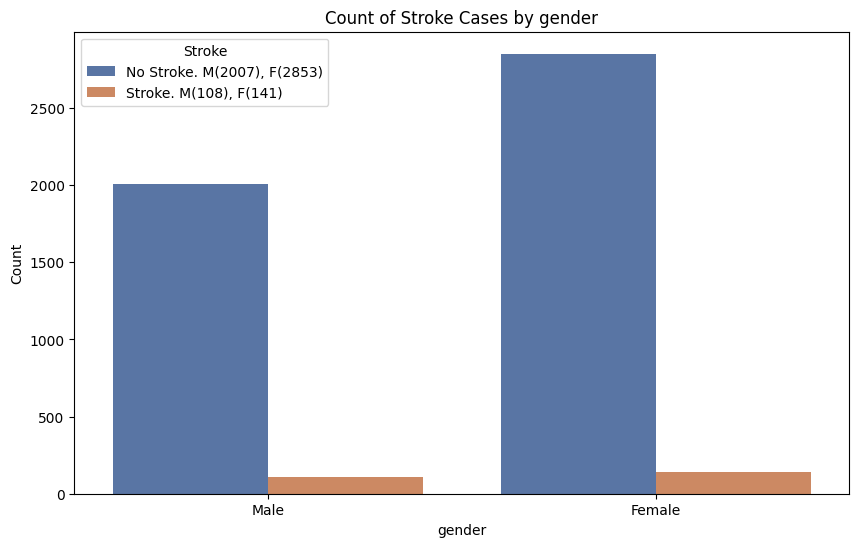

In [ ]:
# Visualize in detail one of those plots
# Example for Gender

# Define the categorical feature you want to evaluate
categorical_feature = 'gender'

# Calculate stroke and non-stroke counts for each category in the categorical feature
stroke_counts = df.groupby([categorical_feature, 'stroke']).size().unstack(fill_value=0)
stroke_counts.columns = ['No Stroke', 'Stroke']

# Create a Count Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=categorical_feature, hue='stroke', palette="deep")
plt.title(f"Count of Stroke Cases by {categorical_feature}")
plt.xlabel(categorical_feature)
plt.ylabel("Count")

plt.legend(title="Stroke", labels=[f"No Stroke. M({stroke_counts.iloc[1,0]}), F({stroke_counts.iloc[0,0]})"
                                   , f"Stroke. M({stroke_counts.iloc[1,1]}), F({stroke_counts.iloc[0,1]})"])
plt.show()


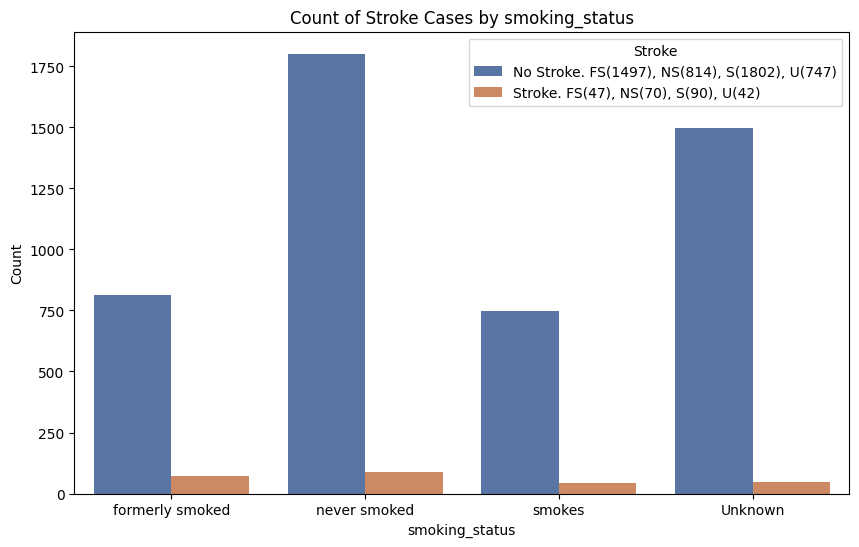

In [ ]:
# Example for Smoking Status

# Define the categorical feature you want to evaluate
categorical_feature = 'smoking_status'

# Calculate stroke and non-stroke counts for each category in the categorical feature
stroke_counts = df.groupby([categorical_feature, 'stroke']).size().unstack(fill_value=0)
stroke_counts.columns = ['No Stroke', 'Stroke']

# Create a Count Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=categorical_feature, hue='stroke', palette="deep")
plt.title(f"Count of Stroke Cases by {categorical_feature}")
plt.xlabel(categorical_feature)
plt.ylabel("Count")

plt.legend(title="Stroke", labels=[f"No Stroke. FS({stroke_counts.iloc[0,0]}), NS({stroke_counts.iloc[1,0]}), S({stroke_counts.iloc[2,0]}), U({stroke_counts.iloc[3,0]})"
                                   , f"Stroke. FS({stroke_counts.iloc[0,1]}), NS({stroke_counts.iloc[1,1]}), S({stroke_counts.iloc[2,1]}), U({stroke_counts.iloc[3,1]})"])
plt.show()


## OUTLIERS DETECTION AND REMOVAL

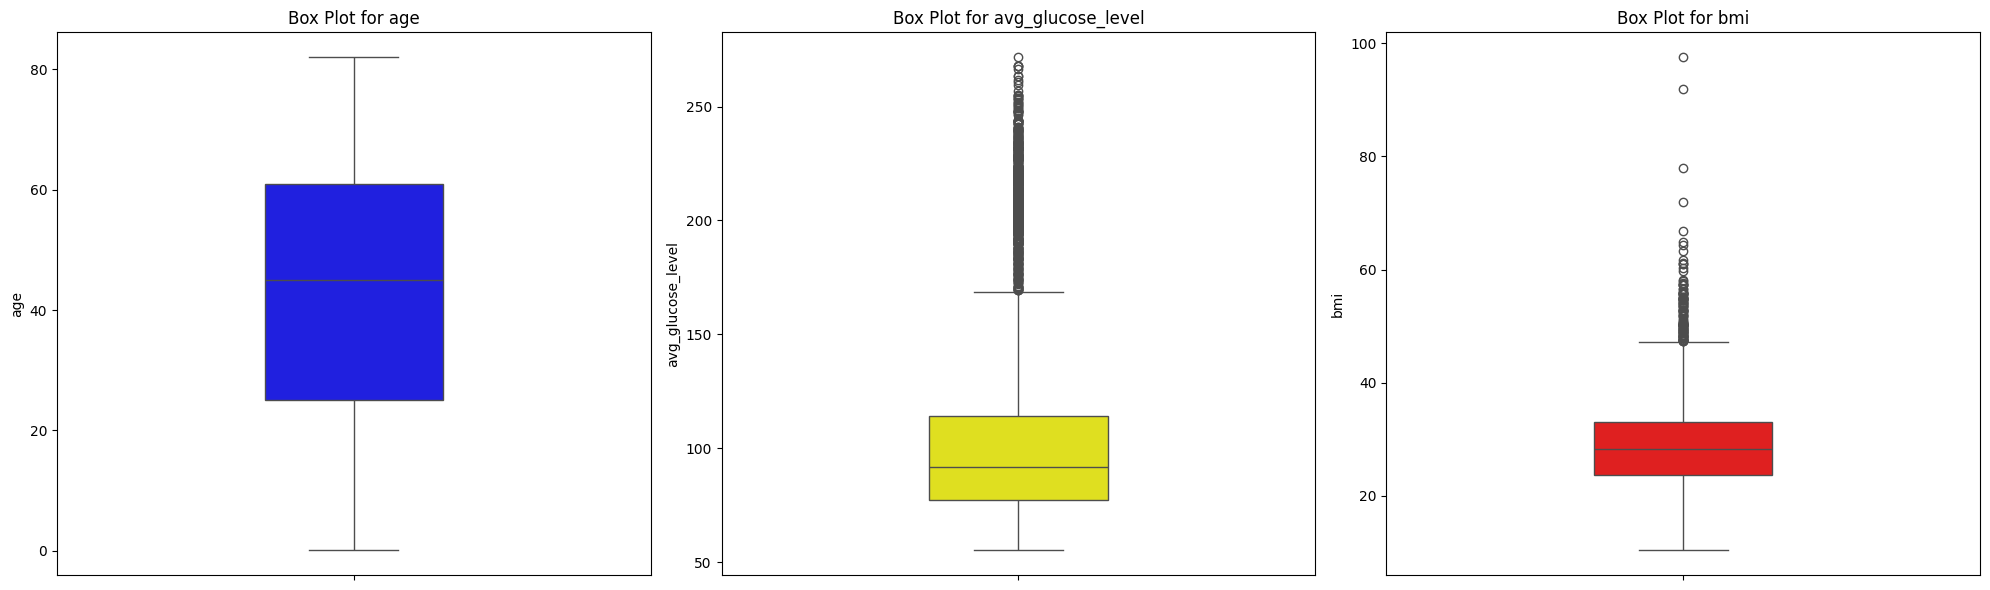

In [ ]:
# Box Plots for numerical features to visualize if there are outliers

# Select numerical features
numerical_columns = df.select_dtypes(exclude=['object', 'int']).columns

# Create a figure with 13 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

axes = axes.flatten()

# Define Colors
colors = ['blue', 'yellow', 'red']

# Iterate over each numerical column and plot a Box Plot
for i, column in enumerate(numerical_columns):
    sns.boxplot(df[column], ax=axes[i], color=colors[i], width=0.3)
    axes[i].set_title(f"Box Plot for {column}")
    axes[i].set_ylabel(f"{column}")

plt.tight_layout()
plt.show()

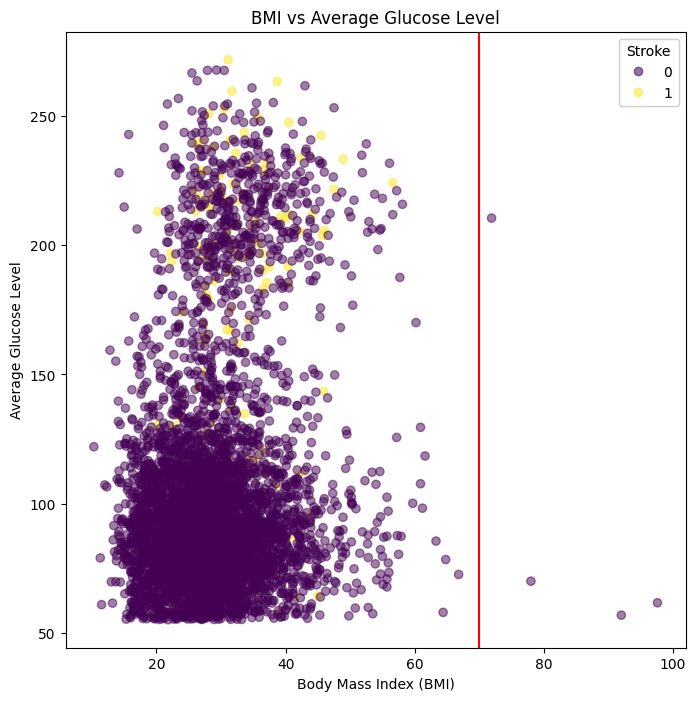

In [ ]:
# Three Option:
    # 1. Graphic method with a Scatter Plot
    # 2. The interquartile range (IQR) method
    # 3. The percentile method with 0.001 and 0.999

# 1. Scatter plot using the two features with outliers: bmi and avg_glucose_level

# Create a scatter plot with points colored according to the stroke feature
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(df['bmi'], df['avg_glucose_level'], c=df['stroke'], cmap='viridis', alpha=0.5)
ax.axvline(70, color='red')

legend1 = ax.legend(*scatter.legend_elements(), title='Stroke')
ax.add_artist(legend1)

ax.set_title('BMI vs Average Glucose Level')
ax.set_xlabel('Body Mass Index (BMI)')
ax.set_ylabel('Average Glucose Level')

plt.show()

In [ ]:
# 2. The interquartile range (IQR) method for bmi feature

feature = 'bmi'
#feature = 'avg_glucose_level'

# Calculate the upper and lower limits
Q1 = df[feature].quantile(0.25)
Q3 = df[feature].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of indexes of the outlier rows
upper_array = np.where(df[feature] >= upper)[0]
lower_array = np.where(df[feature] <= lower)[0]

print(f'len of lower excluded {len(lower_array)}\nlen of upper excluded {len(upper_array)}')

""" # Removing the outliers
print("Old Shape: ", df.shape)

df.drop(index=upper_array, inplace=True)
df.drop(index=lower_array, inplace=True)

# Print the new shape of the DataFrame
print("New Shape: ", df.shape) """

len of lower excluded 0
len of upper excluded 116


' # Removing the outliers\nprint("Old Shape: ", df.shape)\n\ndf.drop(index=upper_array, inplace=True)\ndf.drop(index=lower_array, inplace=True)\n\n# Print the new shape of the DataFrame\nprint("New Shape: ", df.shape) '

In [ ]:
#3. The percentile method with 0.001 and 0.999

feature = 'bmi'

min_thre = df[feature].quantile(0.001)
max_thre = df[feature].quantile(0.999)
min_ex = len(df[df['bmi']<min_thre])
max_ex = len(df[df['bmi']>max_thre])

print(f'len of min excluded {min_ex}\nlen of max excluded {max_ex}')

""" # Removing the outliers
print("Old Shape: ", df.shape)

df.drop(index=df[df['bmi']<min_thre].index, inplace=True)
df.drop(index=df[df['bmi']>max_thre].index, inplace=True)

# Print the new shape of the DataFrame
print("New Shape: ", df.shape) """

len of min excluded 6
len of max excluded 6


' # Removing the outliers\nprint("Old Shape: ", df.shape)\n\ndf.drop(index=df[df[\'bmi\']<min_thre].index, inplace=True)\ndf.drop(index=df[df[\'bmi\']>max_thre].index, inplace=True)\n\n# Print the new shape of the DataFrame\nprint("New Shape: ", df.shape) '

In [ ]:
# Conclusion:
    # 1. Easy and fast method, but too arbitrary
    # 2. The most theoretical method, but too severe because it drops more than 100 samples
    # 3. The most balanced and theoretical choice, we would loose some information from below but not too much

# We can use the third option:

print("Old Shape: ", df.shape)

df.drop(index=df[df['bmi']<min_thre].index, inplace=True)
df.drop(index=df[df['bmi']>max_thre].index, inplace=True)

df.reset_index(drop=True, inplace=True)

# Print the new shape of the DataFrame
print("New Shape: ", df.shape)

Old Shape:  (5109, 11)
New Shape:  (5097, 11)


## FEATURE CORRELATION

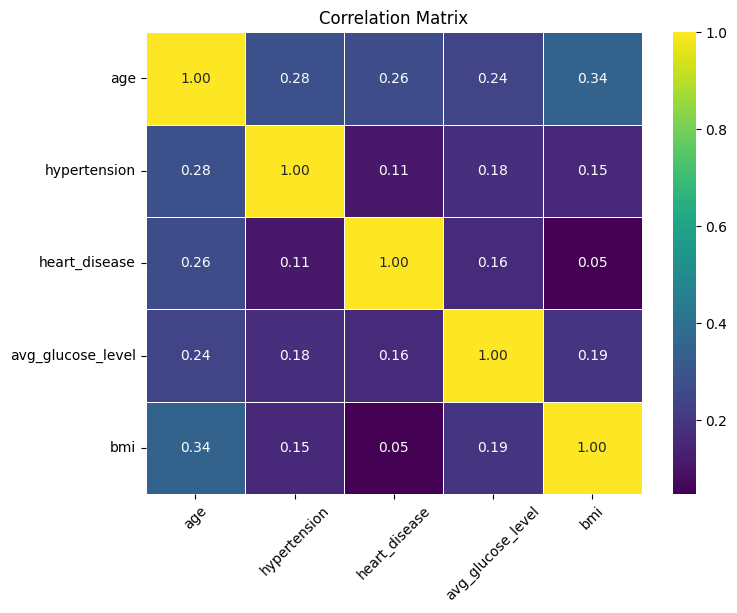

In [ ]:
# Observing Feature Correlation through the use of Heat Map

# Consider just numerical and discrete features, excluding
numerical_columns = df.drop('stroke', axis=1).select_dtypes(exclude='object').columns

corr_matrix = df[numerical_columns].corr()

fig = plt.figure(figsize=(8,6))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation= 45)

plt.show()

In [ ]:
# (JUST FOR CURIOSITY) Encode categorical features so to have a complete correlation matrix

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Choose Categorical features
categorical_columns = df.select_dtypes(include='object').columns

# Encode categorical feature
df_new = df.copy()
for column in categorical_columns:
    df_new[column] = label_encoder.fit_transform(df[column])

#df_new

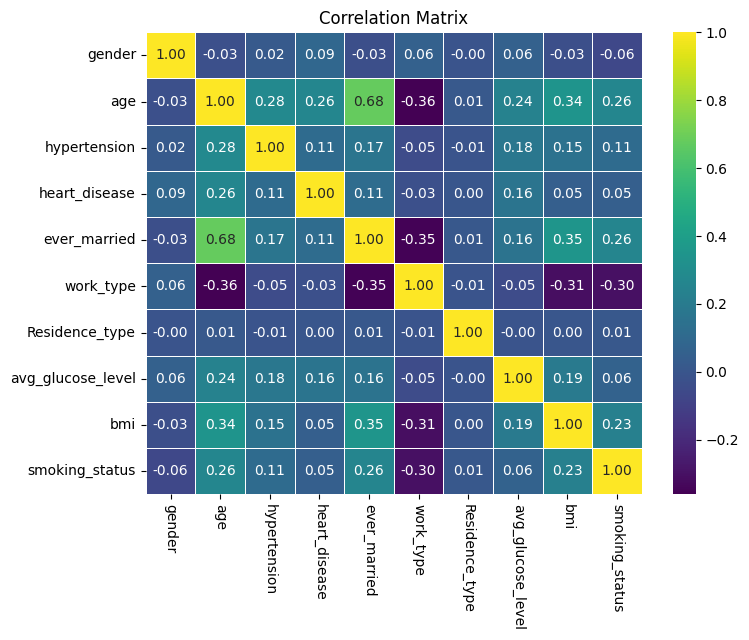

In [ ]:
# Complete Correlation Matrix and Heat Map

corr_matrix = df_new.drop('stroke', axis=1).corr()

fig = plt.figure(figsize=(8,6))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation = -90)

plt.show()

# Conclusion:
    # There aren't clear correlated features
    # The only two slight correlated features are age and ever_married: as expected

## NORMALIZATION

In [ ]:
# Evaluate some Normalization and Standardization techniques

# Inizialize Scaler or Normalizer

#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer(norm='l2')

df_norm = df.copy()

df_norm['bmi'] = scaler.fit_transform(df_norm[['bmi']])
df_norm['avg_glucose_level'] = scaler.fit_transform(df_norm[['avg_glucose_level']])
df_norm['age'] = scaler.fit_transform(df_norm[['age']])

df_norm.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5.097000e+03   5097.000000    5097.000000       5.097000e+03   
mean   1.449803e-16      0.097116       0.054149      -8.364246e-17   
std    1.000098e+00      0.296145       0.226335       1.000098e+00   
min   -1.910743e+00      0.000000       0.000000      -1.127131e+00   
25%   -8.080542e-01      0.000000       0.000000      -6.377436e-01   
50%    7.692875e-02      0.000000       0.000000      -3.150925e-01   
75%    7.849151e-01      0.000000       0.000000       1.751781e-01   
max    1.714147e+00      1.000000       1.000000       3.656762e+00   

                bmi       stroke  
count  5.097000e+03  5097.000000  
mean  -4.488812e-16     0.048852  
std    1.000098e+00     0.215580  
min   -2.103723e+00     0.000000  
25%   -6.885094e-01     0.000000  
50%   -9.332621e-02     0.000000  
75%    5.415359e-01     0.000000  
max    4.694592e+00     1.000000

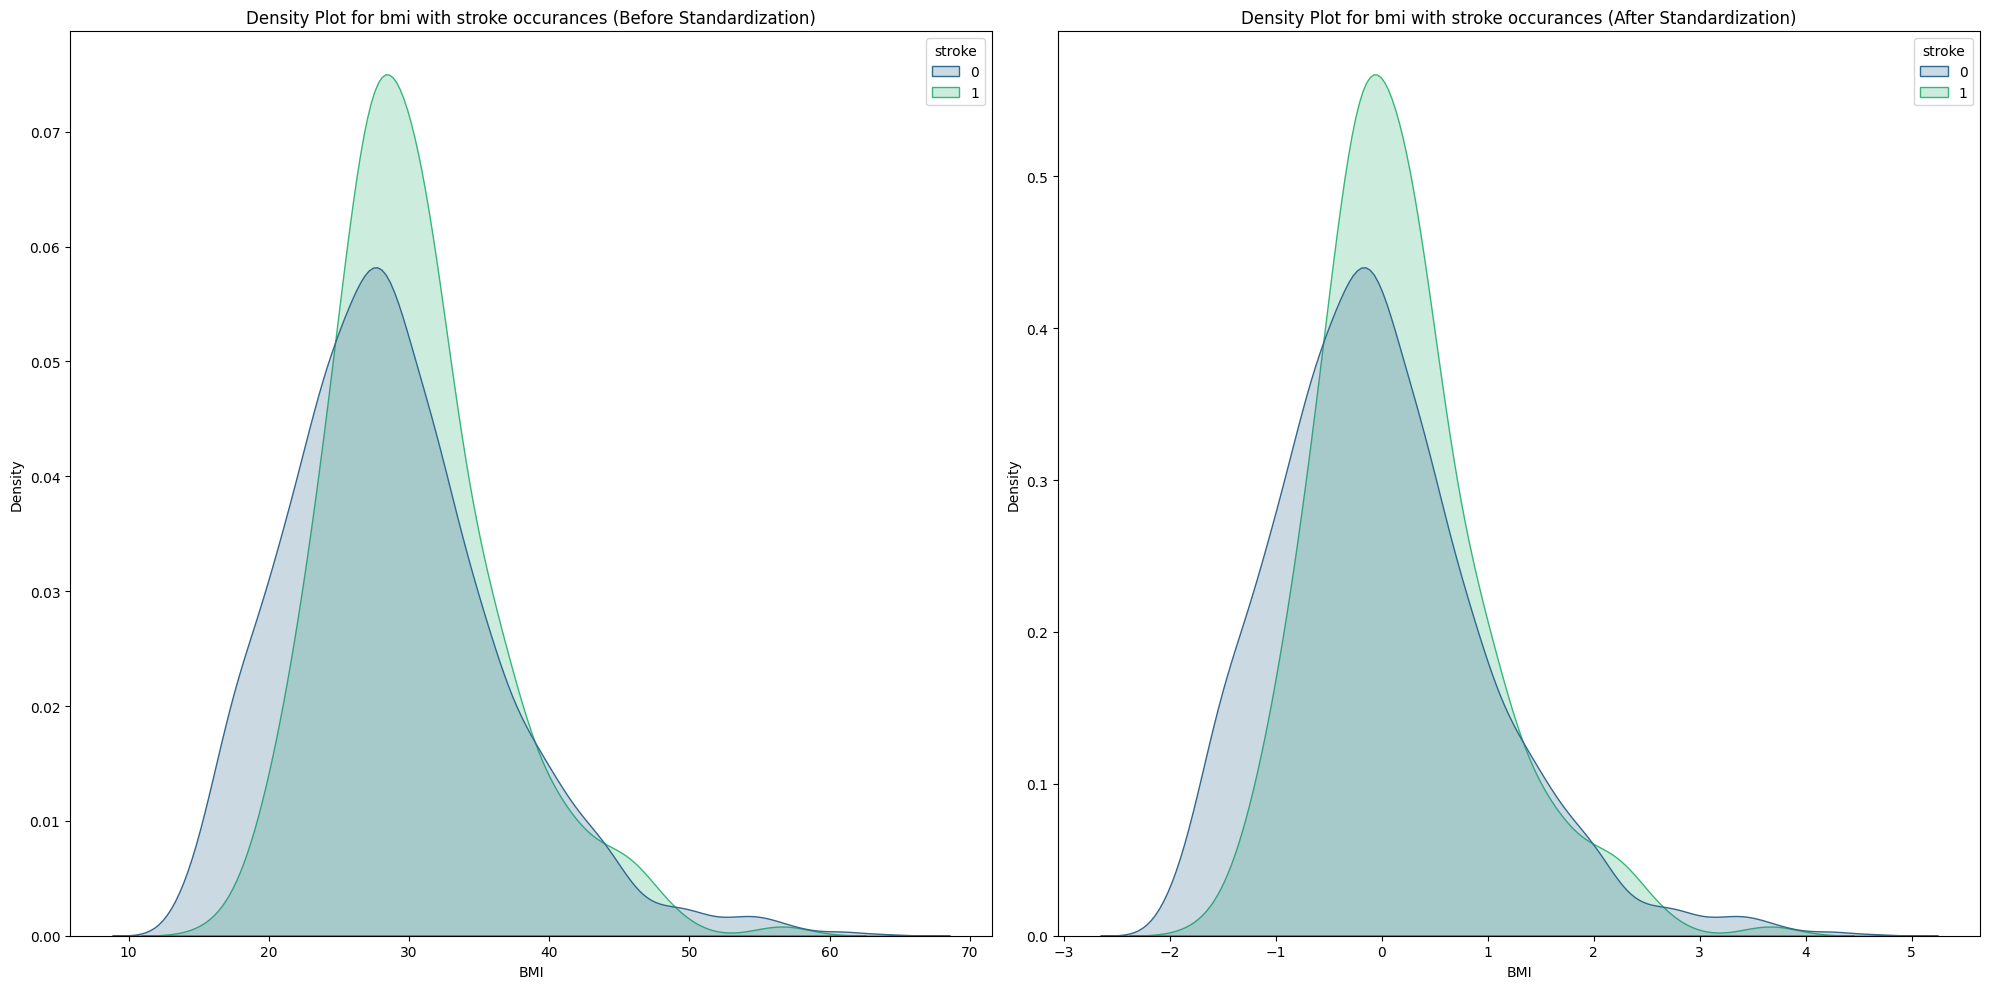

In [ ]:
# Density plot one feature for each 'stroke' category, before and after standardization

feature = 'bmi'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.kdeplot(data=df, x=feature, hue='stroke', fill=True, common_norm=False, palette="viridis", ax=axes[0])
axes[0].set_title(f'Density Plot for {feature} with stroke occurances (Before Standardization)')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Density')

sns.kdeplot(data=df_norm, x=feature, hue='stroke', fill=True, common_norm=False, palette="viridis", ax=axes[1])
axes[1].set_title(f'Density Plot for {feature} with stroke occurances (After Standardization)')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

## ENCODE CATEGORICAL FEATURES

In [ ]:
# Encode categorical features for future machine learning steps and prediction phase

# Define the mapping
# Set up the work_type from the lighter job to the hardest full-time one
# Set up the smoking_status from no smoking status to the increasing options until smokes option
work_type_mapping = {'Govt_job': 4, 'Never_worked': 1, 'Private': 3, 'Self-employed': 2, 'children': 0}
smoking_status = {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 0, 'smokes': 3}

# Apply the mapping
df['work_type'] = df['work_type'].map(work_type_mapping)
df['smoking_status'] = df['smoking_status'].map(smoking_status)
df_norm['work_type'] = df_norm['work_type'].map(work_type_mapping)
df_norm['smoking_status'] = df_norm['smoking_status'].map(smoking_status)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Choose Categorical features
categorical_columns = df.select_dtypes(include='object').columns

# Dict to map the transformation
le_name_mapping = {}

# Encode categorical feature
for column in categorical_columns:

    df[column] = label_encoder.fit_transform(df[column])
    le_name_mapping[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    df_norm[column] = label_encoder.fit_transform(df_norm[column])

#df[categorical_columns]
df_norm[categorical_columns]

gender  ever_married  Residence_type
0          1             1               1
1          0             1               0
2          1             1               0
3          0             1               1
4          0             1               0
...      ...           ...             ...
5092       0             1               1
5093       0             1               1
5094       0             1               0
5095       1             1               0
5096       0             1               1

[5097 rows x 3 columns]

In [ ]:
le_name_mapping

{'gender': {'Female': 0, 'Male': 1},
 'ever_married': {'No': 0, 'Yes': 1},
 'Residence_type': {'Rural': 0, 'Urban': 1}}

## SAVE MODIFIED DATASETS

In [ ]:
# Save the dataset and the normalized dataset in a new folder

df.to_csv('Dataset_after_eda.csv', index=False)
df_norm.to_csv('Normalized_dataset_after_eda.csv', index=False)

## IMPORT LIBRARIES AND DATASET

In [ ]:
# Import dataset after EDA (without normalization)
#df = pd.read_csv('dataset_after_eda/Dataset_after_eda.csv', sep=',')

# Import Normalized dataset after EDA
df = pd.read_csv('Normalized_dataset_after_eda.csv', sep=',')

## UNBALANCED ISSUE

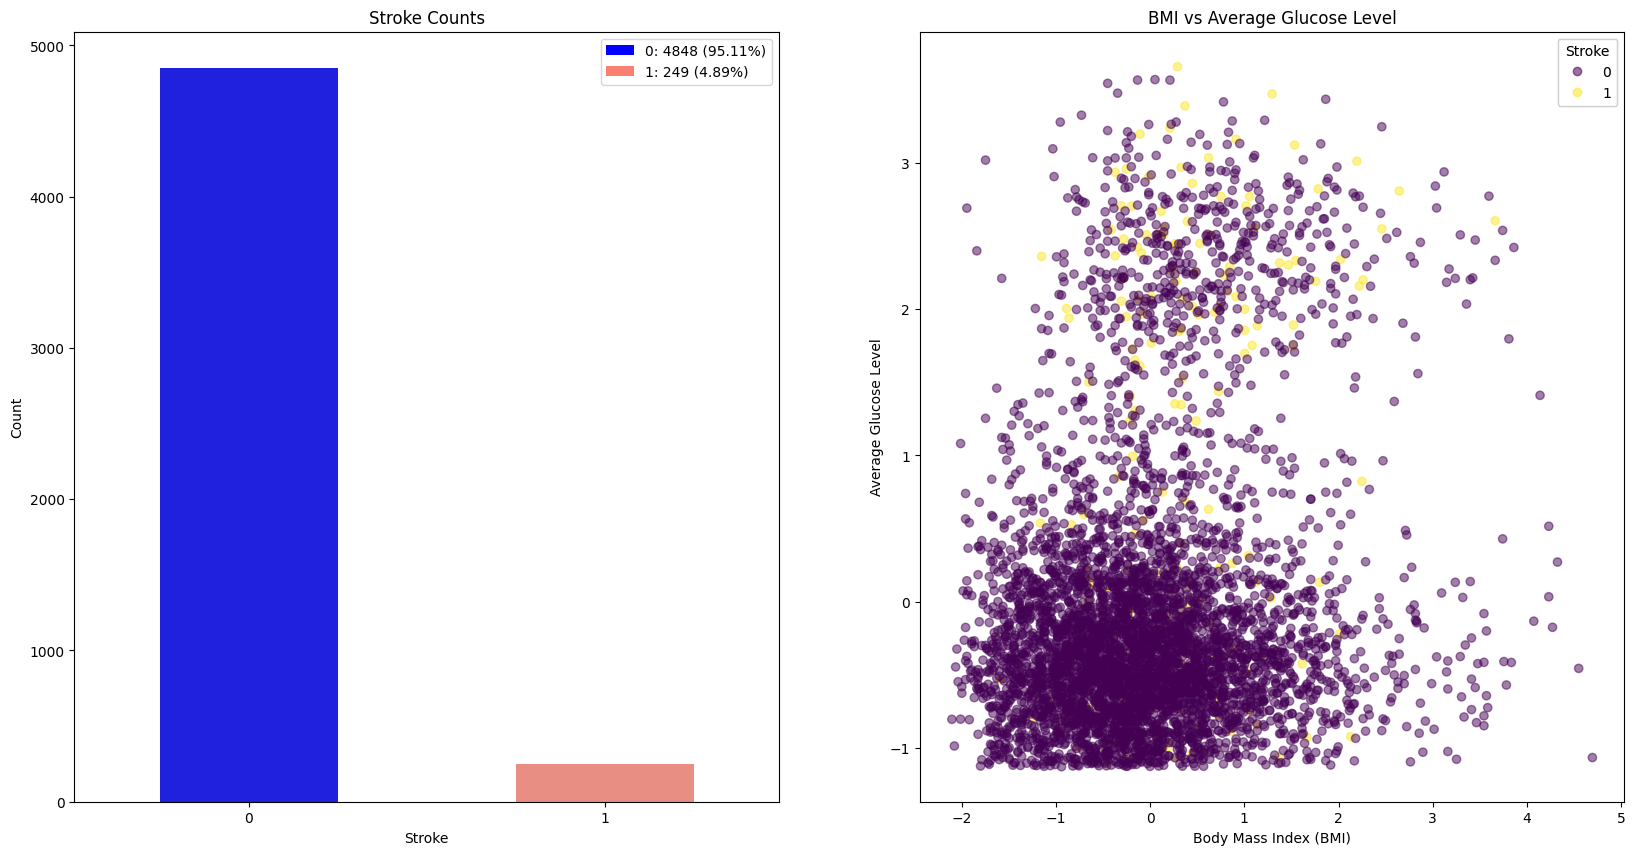

In [ ]:
# Count Plot for stroke
# Create a scatter plot with points colored according to the stroke feature

# Calculate counts for each option
counts = df['stroke'].value_counts()

# Define colors for each option
colors = {0: 'blue', 1: 'salmon'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.countplot(df, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5, ax=axes[0])
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    axes[0].bar(i, 0, color=color, label=f'{i}: {count} ({(count/df.shape[0]*100):.2f}%)')

axes[0].legend(loc='upper right')

scatter = axes[1].scatter(df['bmi'], df['avg_glucose_level'], c=df['stroke'], cmap='viridis', alpha=0.5)

legend1 = axes[1].legend(*scatter.legend_elements(), title='Stroke')
axes[1].add_artist(legend1)

axes[1].set_title('BMI vs Average Glucose Level')
axes[1].set_xlabel('Body Mass Index (BMI)')
axes[1].set_ylabel('Average Glucose Level')

plt.show()

In [ ]:
# Target is 'stroke' which has two values 0 and 1

X = df.drop('stroke', axis=1)
y = df['stroke']

print(f'Entire Dataset Shape:{X.shape}')
print(f'Entire Target Shape:{y.shape}')

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

print(f'New Feature Shape:{X_smote.shape}')
print(f'New Target Shape:{y_smote.shape}')

Entire Dataset Shape:(5097, 10)
Entire Target Shape:(5097,)
New Feature Shape:(9696, 10)
New Target Shape:(9696,)


Text(0, 0.5, 'Average Glucose Level')

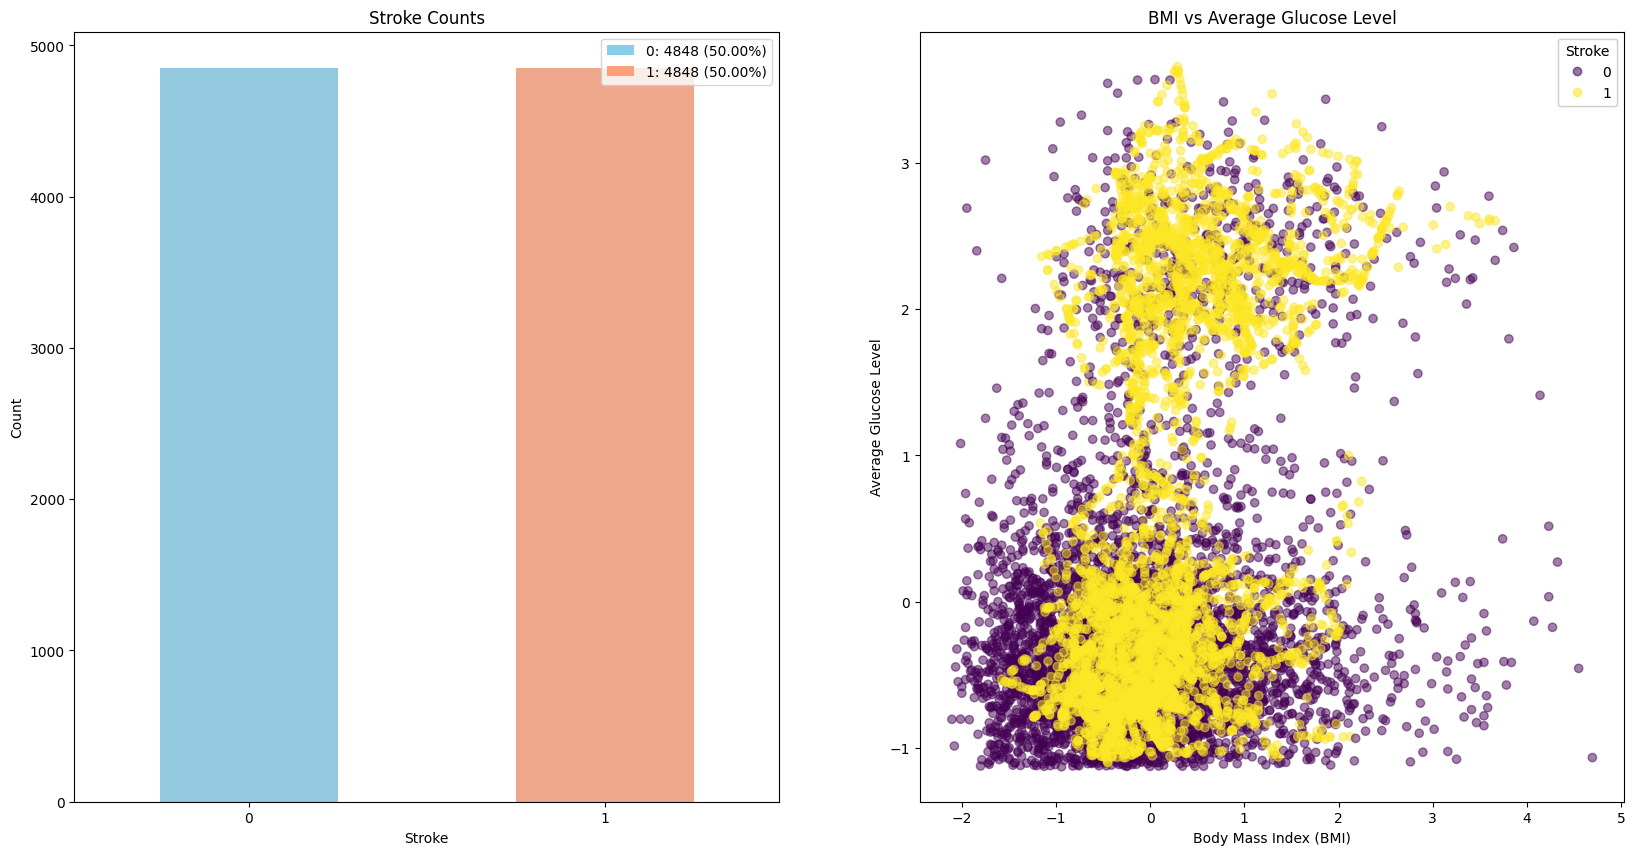

In [ ]:
# Unbalanced issue [SOLVED]

# Balanced df
df_balanced = pd.DataFrame()
df_balanced[X.columns] = X_smote
df_balanced['stroke'] = y_smote

# Calculate counts for each option
counts = df_balanced['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.countplot(df_balanced, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5, ax=axes[0])
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    axes[0].bar(i, 0, color=color, label=f'{i}: {count} ({(count/df_balanced.shape[0]*100):.2f}%)')

axes[0].legend(loc='upper right')

scatter = axes[1].scatter(df_balanced['bmi'], df_balanced['avg_glucose_level'], c=df_balanced['stroke'], cmap='viridis', alpha=0.5)

legend1 = axes[1].legend(*scatter.legend_elements(), title='Stroke')
axes[1].add_artist(legend1)

axes[1].set_title('BMI vs Average Glucose Level')
axes[1].set_xlabel('Body Mass Index (BMI)')
axes[1].set_ylabel('Average Glucose Level')

## CROSS-VALIDATION PREDICTION

In [ ]:
# Define machine learning classifier with default parameters

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('eXtreme Gradient Boosting', XGBClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('K-nearest neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB())
]

print(f'Evaluation using {len(models)} Machine Learning Classifiers')

Evaluation using 8 Machine Learning Classifiers


In [ ]:
# Perform iterated 10-fold stratified cross-validation for each model

# DF to save results
results_test_iter = pd.DataFrame()
results_train_iter = pd.DataFrame()
results_test = pd.DataFrame()
results_train = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
train_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 5

for name, model in models:

    print(f'Evaluating model: {name}...')

    # Define dict for each metric for both test and train predictions
    test_metrics = {
        'Accuracy' : [],
        'Precision' : [],
        'Recall' : [],
        'F1 Score' : [],
        'AUC' : []
    }

    train_metrics = {
        'Accuracy' : [],
        'Precision' : [],
        'Recall' : [],
        'F1 Score' : [],
        'AUC' : []
    }

    test_confusion_matrices = []
    train_confusion_matrices = []
    roc_auc_curves = []

    for i in range(0,num_iter):

        # Set up stratified CV
        stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)

        for train_index, test_index in stratified_cv.split(X_smote, y_smote):

            X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
            y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

            model.fit(X_train_fold, y_train_fold)

            # predictions
            y_pred_fold = model.predict(X_test_fold)
            y_pred_train = model.predict(X_train_fold)

            # metrics calculation for test
            test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
            test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
            test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
            test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
            test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))

            # metrics calculation for train
            train_metrics['Accuracy'].append(accuracy_score(y_train_fold, y_pred_train))
            train_metrics['Precision'].append(precision_score(y_train_fold, y_pred_train))
            train_metrics['Recall'].append(recall_score(y_train_fold, y_pred_train))
            train_metrics['F1 Score'].append(f1_score(y_train_fold, y_pred_train))
            train_metrics['AUC'].append(roc_auc_score(y_train_fold, y_pred_train))

            # Calculate confusion matrices
            test_confusion_matrices.append(confusion_matrix(y_test_fold, y_pred_fold))
            train_confusion_matrices.append(confusion_matrix(y_train_fold, y_pred_train))

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test_fold, model.predict_proba(X_test_fold)[:, 1])
            roc_auc_curves.append((fpr, tpr))

    # Collecting metric values for eahc iteration for each model (both train and test)
    metric_test_iter = {
        metric : value for metric, value in test_metrics.items()
    }
    cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
    results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
    results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)

    metric_train_iter = {
        metric : value for metric, value in train_metrics.items()
    }
    results_train_iter_medium = pd.DataFrame(metric_train_iter.values(), columns=cols_iter)
    results_train_iter = pd.concat([results_train_iter, results_train_iter_medium], axis=1)

    # Collecting mean and std values for each metric and for each model (both train and test)
    mean_folds_metrics = {
        metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
    }

    cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])

    res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
    results_test = pd.concat([results_test, res_test_medium], axis=1)

    mean_train_metrics = {
        metric : (np.mean(value), np.std(value)) for metric, value in train_metrics.items()
    }

    res_train_medium = pd.DataFrame(mean_train_metrics.values(), columns=cols)
    results_train = pd.concat([results_train, res_train_medium], axis=1)

    # Save confusion matrices and ROC curves
    test_confusion[name] = test_confusion_matrices
    train_confusion[name] = train_confusion_matrices
    roc[name] = roc_auc_curves

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_train.index = mean_train_metrics.keys()
results_test_iter.index = metric_test_iter.keys()
results_train_iter.index = metric_train_iter.keys()

Evaluating model: Logistic Regression...
Evaluating model: Decision Tree...
Evaluating model: Random Forest...
Evaluating model: Gradient Boosting...
Evaluating model: eXtreme Gradient Boosting...
Evaluating model: Support Vector Machine...
Evaluating model: K-nearest neighbors...
Evaluating model: Naive Bayes...


In [ ]:
# Show test results for each classifier and each metric (mean and std)
results_test

Logistic Regression           Decision Tree           Random Forest  \
                         Mean       Std          Mean       Std          Mean   
Accuracy             0.784634  0.010988      0.908272  0.011452      0.939315   
Precision            0.763766  0.012154      0.900793  0.015424      0.913681   
Recall               0.824544  0.018131      0.917905  0.014318      0.970464   
F1 Score             0.792857  0.011037      0.909161  0.011166      0.941170   
AUC                  0.784633  0.010987      0.908270  0.011454      0.939315   

                    Gradient Boosting           eXtreme Gradient Boosting  \
                Std              Mean       Std                      Mean   
Accuracy   0.007292          0.850165  0.009091                  0.930858   
Precision  0.010870          0.814642  0.011542                  0.917890   
Recall     0.007724          0.906930  0.012994                  0.946577   
F1 Score   0.006886          0.858220  0.008362                  0.931930   
AUC        0.007299          0.850164  0.009100                  0.930858   

                    Support Vector Machine           K-nearest neighbors  \
                Std                   Mean       Std                Mean   
Accuracy   0.007819               0.813882  0.010067            0.888139   
Precision  0.011420               0.773846  0.011865            0.826310   
Recall     0.011909               0.887416  0.016454            0.983252   
F1 Score   0.007651               0.826617  0.009338            0.897913   
AUC        0.007822               0.813881  0.010072            0.888139   

                    Naive Bayes            
                Std        Mean       Std  
Accuracy   0.009420    0.748660  0.011789  
Precision  0.012863    0.714930  0.012558  
Recall     0.005587    0.827682  0.017655  
F1 Score   0.007839    0.767049  0.010788  
AUC        0.009434    0.748660  0.011794

In [ ]:
# Show train results for each classifier and each metric (mean and std)
results_train

Logistic Regression           Decision Tree      Random Forest  \
                         Mean       Std          Mean  Std          Mean   
Accuracy             0.785316  0.001502           1.0  0.0      0.999998   
Precision            0.764314  0.001482           1.0  0.0      1.000000   
Recall               0.825046  0.001862           1.0  0.0      0.999995   
F1 Score             0.793519  0.001465           1.0  0.0      0.999998   
AUC                  0.785316  0.001501           1.0  0.0      0.999998   

                    Gradient Boosting           eXtreme Gradient Boosting  \
                Std              Mean       Std                      Mean   
Accuracy   0.000016          0.864114  0.002299                  0.986831   
Precision  0.000000          0.828621  0.002714                  0.983665   
Recall     0.000032          0.918134  0.004141                  0.990108   
F1 Score   0.000016          0.871076  0.002249                  0.986874   
AUC        0.000016          0.864113  0.002299                  0.986831   

                    Support Vector Machine           K-nearest neighbors  \
                Std                   Mean       Std                Mean   
Accuracy   0.001295               0.819293  0.001329            0.916135   
Precision  0.002084               0.779226  0.001879            0.861932   
Recall     0.001623               0.891052  0.002330            0.991020   
F1 Score   0.001286               0.831392  0.001174            0.921978   
AUC        0.001296               0.819293  0.001330            0.916135   

                    Naive Bayes            
                Std        Mean       Std  
Accuracy   0.000994    0.749058  0.001352  
Precision  0.001539    0.715183  0.001623  
Recall     0.000865    0.827782  0.001934  
F1 Score   0.000858    0.767372  0.001152  
AUC        0.000996    0.749058  0.001352

In [ ]:
# Show train results for each classifier and each metric (over every iterations)
results_train_iter

Logistic Regression                                          \
                            0         1         2         3         4   
Accuracy             0.787532  0.785354  0.783291  0.786042  0.786500   
Precision            0.766066  0.764331  0.762198  0.765306  0.765618   
Recall               0.827871  0.825120  0.823516  0.825120  0.825808   
F1 Score             0.795770  0.793563  0.791671  0.794088  0.794575   
AUC                  0.787532  0.785354  0.783291  0.786042  0.786500   

                                                             ... Naive Bayes  \
                  5         6         7         8         9  ...          40   
Accuracy   0.784667  0.782170  0.785493  0.787327  0.784920  ...    0.747651   
Precision  0.764368  0.760695  0.763710  0.766355  0.764631  ...    0.713074   
Recall     0.823058  0.823287  0.826725  0.826764  0.823327  ...    0.828788   
F1 Score   0.792628  0.790754  0.793969  0.795414  0.792894  ...    0.766589   
AUC        0.784667  0.782175  0.785498  0.787322  0.784916  ...    0.747651   

                                                                       \
                 41        42        43        44        45        46   
Accuracy   0.750745  0.749713  0.749140  0.748797  0.749599  0.748253   
Precision  0.716377  0.715871  0.715418  0.715078  0.716501  0.713694   
Recall     0.830163  0.828100  0.827412  0.827183  0.826037  0.829017   
F1 Score   0.769084  0.767906  0.767350  0.767056  0.767380  0.767045   
AUC        0.750745  0.749713  0.749140  0.748797  0.749599  0.748262   

                                         
                 47        48        49  
Accuracy   0.748367  0.749742  0.749742  
Precision  0.714597  0.715842  0.715671  
Recall     0.826954  0.828368  0.828827  
F1 Score   0.766681  0.768005  0.768104  
AUC        0.748376  0.749733  0.749733  

[5 rows x 400 columns]

## RESULTS VISUALIZATION

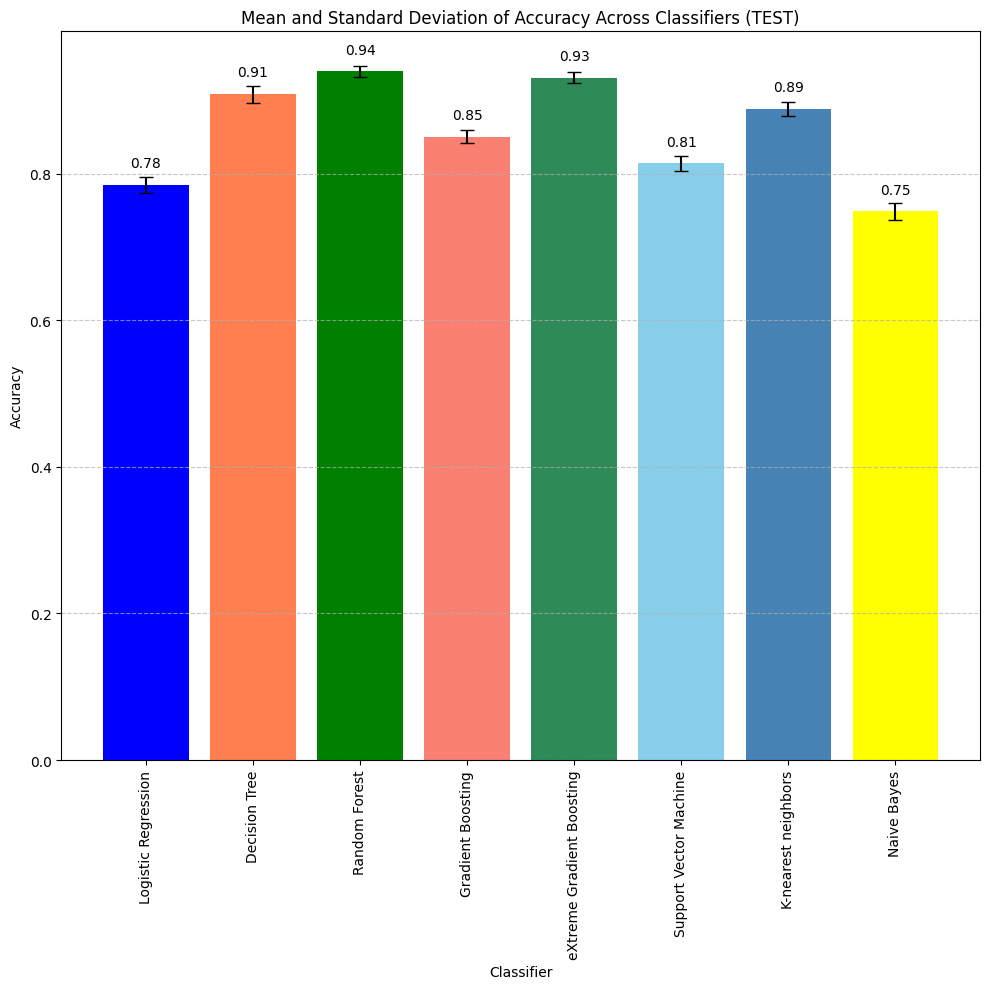

In [ ]:
#  Bar plot for each classifiers to visualize one of the evaluation metrics with mean and std values (using TEST results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting',
               'eXtreme Gradient Boosting', 'Support Vector Machine', 'K-nearest neighbors', 'Naive Bayes']

metric = 'Accuracy'

# Define colors for each bar
light_colors = ['blue', 'coral', 'green', 'salmon', 'seagreen', 'skyblue', 'steelblue', 'yellow']

plt.figure(figsize=(10, 10))

bars = plt.bar(classifiers, results_test.loc[:, (slice(None), 'Mean')].loc[metric],
               yerr = results_test.loc[:, (slice(None), 'Std')].loc[metric],
                capsize=5, color=light_colors)

# Annotate each bar with its mean value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, round(height, 2),
             ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Mean and Standard Deviation of {metric} Across Classifiers (TEST)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


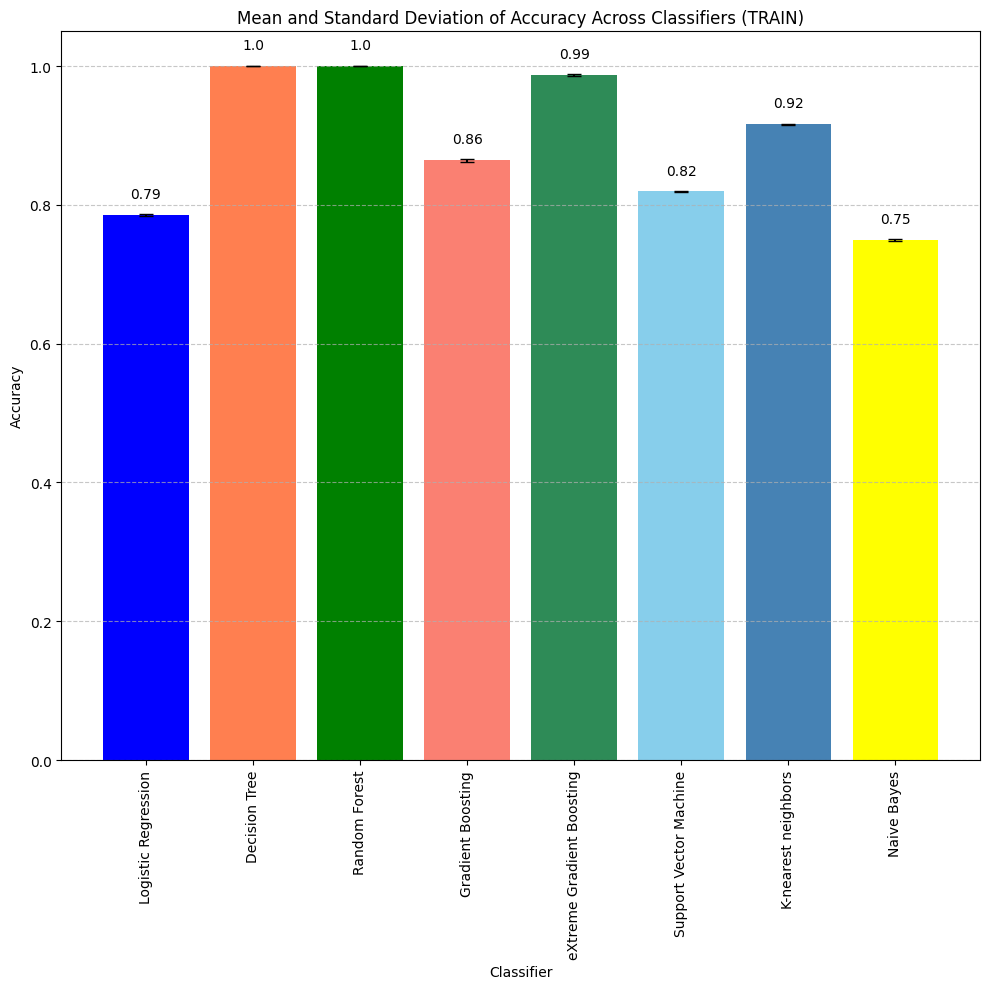

In [ ]:
#  Bar plot for each classifiers to visualize one of the evaluation metrics with mean and std values (using TRAIN results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting',
               'eXtreme Gradient Boosting', 'Support Vector Machine', 'K-nearest neighbors', 'Naive Bayes']

metric = 'Accuracy'

# Define colors for each bar
light_colors = ['blue', 'coral', 'green', 'salmon', 'seagreen', 'skyblue', 'steelblue', 'yellow']

plt.figure(figsize=(10, 10))

bars = plt.bar(classifiers, results_train.loc[:, (slice(None), 'Mean')].loc[metric],
               yerr=results_train.loc[:, (slice(None), 'Std')].loc[metric], capsize=5, color=light_colors)

# Annotate each bar with its mean value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, round(height, 2),
             ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Mean and Standard Deviation of {metric} Across Classifiers (TRAIN)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

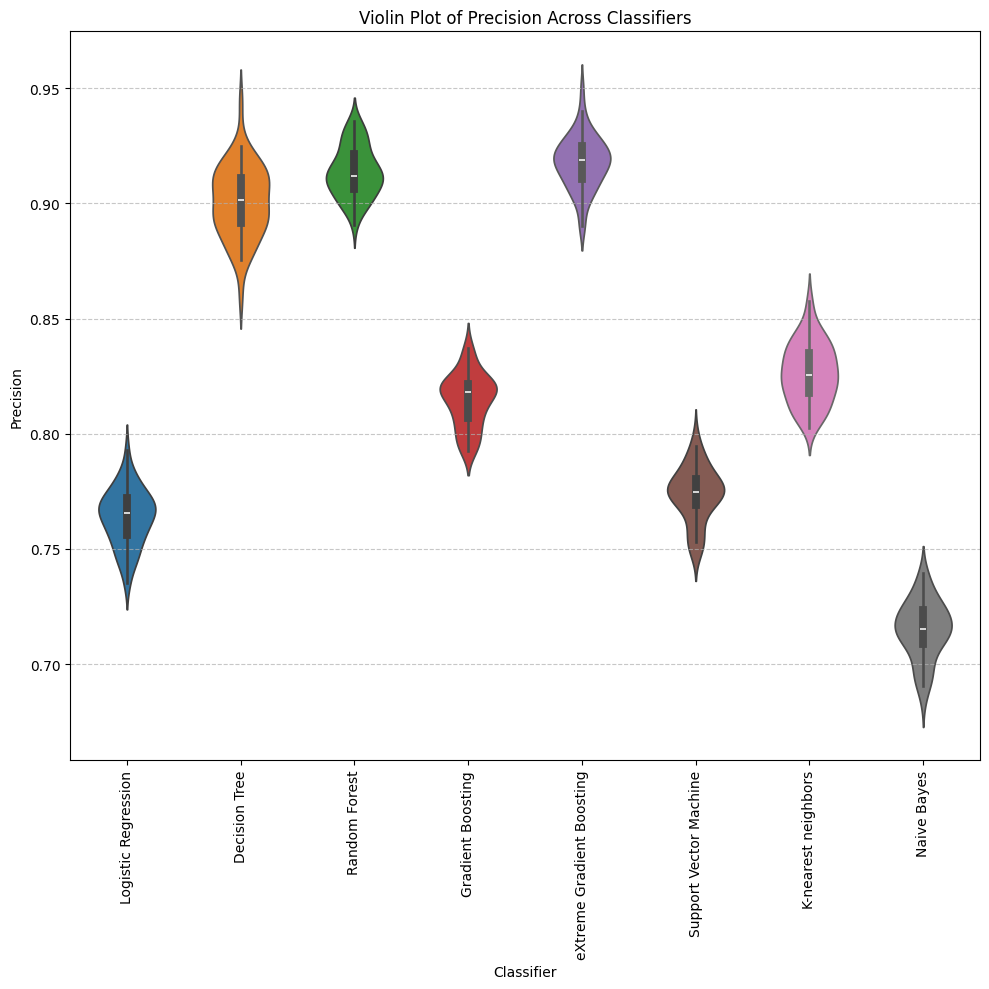

In [ ]:
# Violin Plot for the iteration values (using TEST results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting',
               'eXtreme Gradient Boosting', 'Support Vector Machine', 'K-nearest neighbors', 'Naive Bayes']

metric = 'Precision'

plt.figure(figsize=(10, 10))

for classifier in classifiers:
    data_df = pd.DataFrame(results_test_iter.loc[:, (classifier, [str(j) for j in range(0,num_iter*10)])].loc[metric])

    sns.violinplot(x=data_df.index.get_level_values(0), y = metric, data=data_df, width=0.5)

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Violin Plot of {metric} Across Classifiers')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

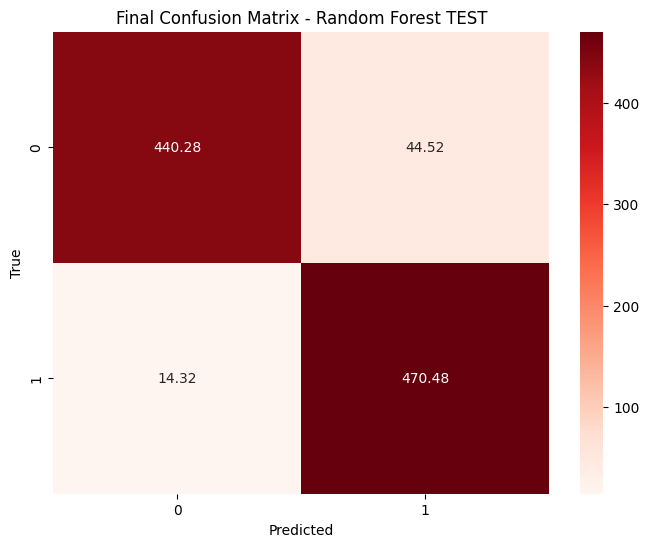

In [ ]:
# Display final confusion matrix for each model (using TEST results)

model_name = 'Random Forest'
confusion_matrix_mean = np.mean(test_confusion[model_name], axis=0)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix_mean, annot=True, cmap='Reds', fmt='g')

plt.title(f'Final Confusion Matrix - {model_name} TEST')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

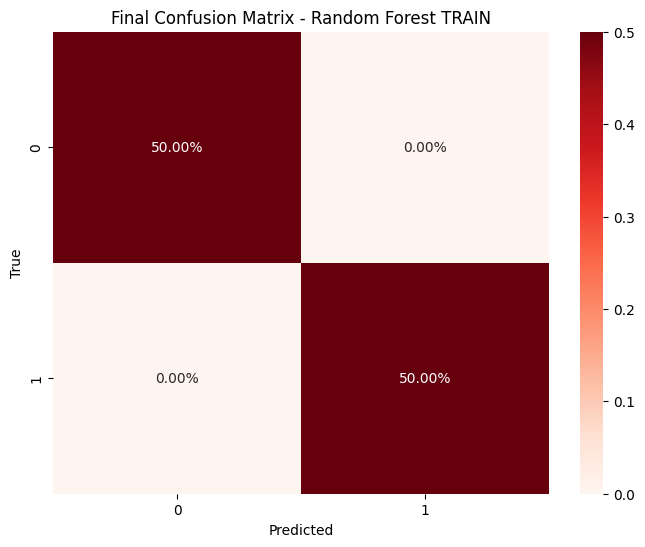

In [ ]:
# Display final confusion matrix for each model (using TRAIN results)

model_name = 'Random Forest'
confusion_matrix_mean = np.mean(train_confusion[model_name], axis=0)

plt.figure(figsize=(8, 6))

#sns.heatmap(confusion_matrix_mean, annot=True, cmap='Reds', fmt='g')

# If you prefer percentage information
sns.heatmap(confusion_matrix_mean/np.sum(confusion_matrix_mean), annot=True, cmap='Reds', fmt='.2%')

plt.title(f'Final Confusion Matrix - {model_name} TRAIN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

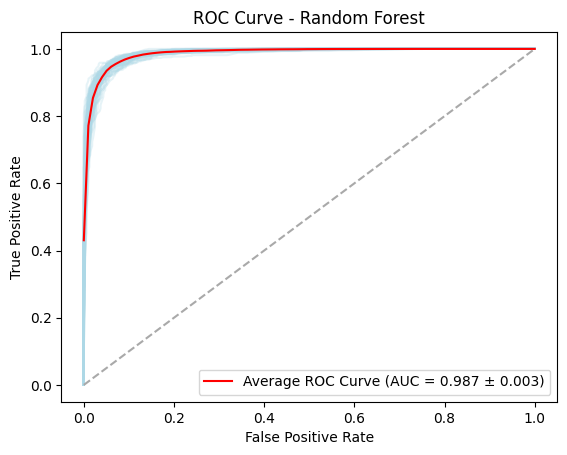

In [ ]:
# Display Average ROC curve and curves for each iteration, for each model (using TEST results)

model_name = 'Random Forest'

mean_fpr = np.linspace(0, 1, 100)
tprs = []
auc_scores = []
for curve in roc[model_name]:

        # Calculate AUC for each ROC curve
        auc_score = auc(curve[0], curve[1])
        auc_scores.append(auc_score)

        #auc_std = np.std(auc_scores)

        plt.plot(curve[0], curve[1], color='lightblue', alpha=0.3)

        tprs.append(np.interp(mean_fpr, curve[0], curve[1]))

auc_std = np.std(auc_scores)
mean_tpr = np.mean(tprs, axis=0)

#plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'Average ROC Curve (AUC = {auc(mean_fpr, mean_tpr):.3f} ± {auc_std:.3f})')
plt.plot(mean_fpr, mean_tpr, color='red', label=f'Average ROC Curve (AUC = {np.mean(auc_scores):.3f} ± {auc_std:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='darkgrey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name}')
plt.legend(loc="lower right")
plt.show()

## HYPERPARAMETERS TUNING

In [ ]:
# After the evaluation on the best classifier with default parameters, Found out that the best classifier to use is Random Forest
# Tried tuning its hyperparameters just for curiosity and to check that default parameters were a good choice.

# Nested CV: two stratified k fold croos-validation methods: outer and inner CV.

# Define features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

# Define the classifier
classifier = RandomForestClassifier(random_state=59)
#classifier = SVC(random_state=59)

# Define the grid of hyperparameters to search for RANDOM FOREST
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Define the grid of hyperparameters to search for SVM --> it requires too much time
""" param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
} """

# Lists to store results
best_params_list = []
test_scores = []

# Set up a nested cross-validation with stratified k-fold
outer_stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)

for i, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X_smote, y_smote)):

    print(f"Fold {i+1}...")

    # Define train and test
    X_train, X_test = X_smote.iloc[train_index], X_smote.iloc[test_index]
    y_train, y_test = y_smote.iloc[train_index], y_smote.iloc[test_index]

    # Set up the inner stratified k-fold cross-validation
    inner_stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=59)

    # Set up and fit the grid
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=inner_stratified_kfold)
    grid_search.fit(X_train, y_train)

    best_params_list.append(grid_search.best_params_)

    best_rf_classifier = grid_search.best_estimator_
    test_score = best_rf_classifier.score(X_test, y_test)
    test_scores.append(test_score)

Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...


In [ ]:
# Show the results for each fold and the mean and std value

print("Best hyperparameters found for each fold:")
for i, (best_params, score) in enumerate(zip(best_params_list, test_scores)):
    print(f"Fold {i+1} with acc = {score:.3f}: {best_params}")

print(f"Mean test score across all folds: {np.mean(test_scores):.3f} ± {np.std(test_scores):.3f}")

Best hyperparameters found for each fold:
Fold 1 with acc = 0.932: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 2 with acc = 0.941: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 3 with acc = 0.935: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Fold 4 with acc = 0.927: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 5 with acc = 0.931: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean test score across all folds: 0.933 ± 0.005


## FEATURE IMPORTANCE

Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Fold 6...
Fold 7...
Fold 8...
Fold 9...
Fold 10...


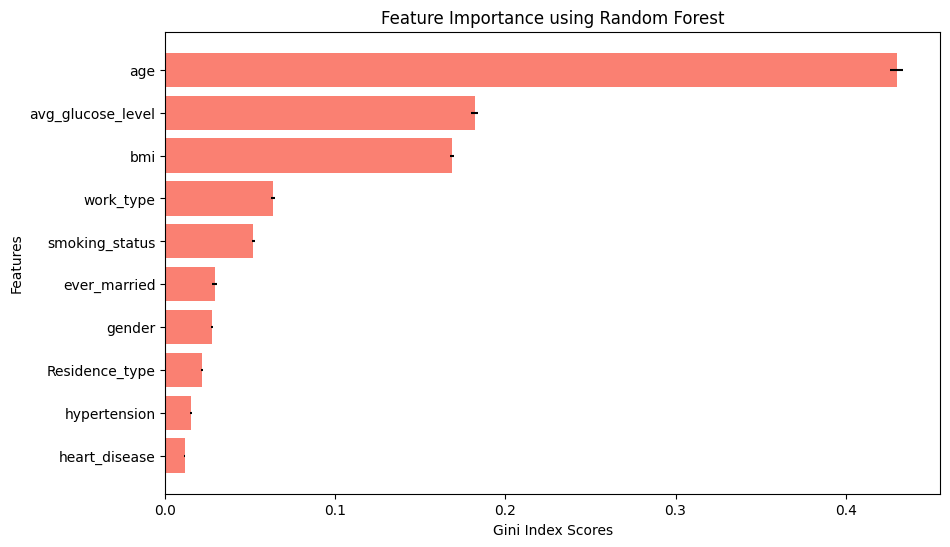

In [ ]:
# First evaluation of Global Feature Importance through the mean of Gini Index Criterio

# Define features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

# Initialize a random forest classifier
rf = RandomForestClassifier(criterion = 'gini', random_state=59)

# Set up a nested cross-validation with stratified k-fold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

feature_importances = []

for i, (train_index, test_index) in enumerate(stratified_kfold.split(X_smote, y_smote)):

    print(f"Fold {i+1}...")

    # Define train and test
    X_train, X_test = X_smote.iloc[train_index], X_smote.iloc[test_index]
    y_train, y_test = y_smote.iloc[train_index], y_smote.iloc[test_index]

    # Fit classifier
    rf.fit(X_train, y_train)

    # Append feature importances
    feature_importances.append(rf.feature_importances_)

# Compute mean importance across folds
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Sort features by mean importance
sorted_indices = np.argsort(mean_importances)

# Plot feature importances

plt.figure(figsize=(10, 6))

plt.barh(range(len(sorted_indices)), mean_importances[sorted_indices], xerr=std_importances[sorted_indices] , color='salmon')

plt.yticks(range(len(sorted_indices)), [X.columns[i] for i in sorted_indices])
plt.xlabel("Gini Index Scores")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()

## IMPORT LIBRARIES AND DATASET

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, roc_curve, auc

import shap
from IPython.display import HTML

In [ ]:
# Import dataset after EDA (without normalization)
#df = pd.read_csv('Dataset_after_eda.csv', sep=',')

# Import Normalized dataset after EDA
df = pd.read_csv('Normalized_dataset_after_eda.csv', sep=',')


In [ ]:
# Target is 'stroke' which has two values 0 and 1

X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

## Shapley values in 10 folds Cross-Validation without iteration

In [ ]:
# Perform iterated 10-fold stratified cross-validation for each model (WITHOUT ITERATIONS)

# DF to save results
results_test_iter = pd.DataFrame()
results_test = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 1

# Define dict for each metric for both test predictions
test_metrics = {
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1 Score' : [],
    'AUC' : []
}

# List to store importance values to plot a feature importance
feature_importances = []

# Lists to store shapley values and baseline values for each class: stroke = [0,1]
shap_values_for_folds_0 = []
baseline_values_for_folds_0 = []
shap_values_for_folds_1 = []
baseline_values_for_folds_1 = []

# Define model
model = RandomForestClassifier(random_state=59)
name = "Random Forest"

# List to save the order of test samples in each CV fold
ix_test = []

for i in range(0,num_iter):

    # Set up stratified CV
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)

    for j, (train_index, test_index) in enumerate(stratified_cv.split(X_smote, y_smote)):

        print(f'Split {j+1}...')

        ix_test.append(test_index)

        X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
        y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)

        # predictions
        y_pred_fold = model.predict(X_test_fold)

        # Define explainer for SHAP
        explainer = shap.Explainer(model)

        # Shapley values and baselines for X_test_fold
        shap_values = explainer(X_test_fold).values
        baselines = explainer(X_test_fold).base_values

        # Store Shapley values and baselines for each CV fold
        shap_values_for_folds_0.append(shap_values[:,:,0])
        shap_values_for_folds_1.append(shap_values[:,:,1])
        baseline_values_for_folds_0.append(baselines[:,0])
        baseline_values_for_folds_1.append(baselines[:,1])

        # metrics calculation for test
        test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
        test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
        test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
        test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))

        # Append feature importances
        feature_importances.append(model.feature_importances_)

# Collecting metric values for eahc iteration for each model (both train and test)
metric_test_iter = {
    metric : value for metric, value in test_metrics.items()
}
cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)


# Collecting mean and std values for each metric and for each model (both train and test)
mean_folds_metrics = {
    metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
}
cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])
res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
results_test = pd.concat([results_test, res_test_medium], axis=1)

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_test_iter.index = metric_test_iter.keys()

# Create a list for the index of the test subjects
list_index_test = [element for array in ix_test for element in array]

# Create an array for the Shapley values for each test subject
array_shap_1 = np.array([element for shapley in shap_values_for_folds_1 for element in shapley])
array_shap_0 = np.array([element for shapley in shap_values_for_folds_0 for element in shapley])

# Create an array for the base values for each test subject
array_baseline_1 = np.array([element for shapley in baseline_values_for_folds_1 for element in shapley])
array_baseline_0 = np.array([element for shapley in baseline_values_for_folds_0 for element in shapley])

Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...


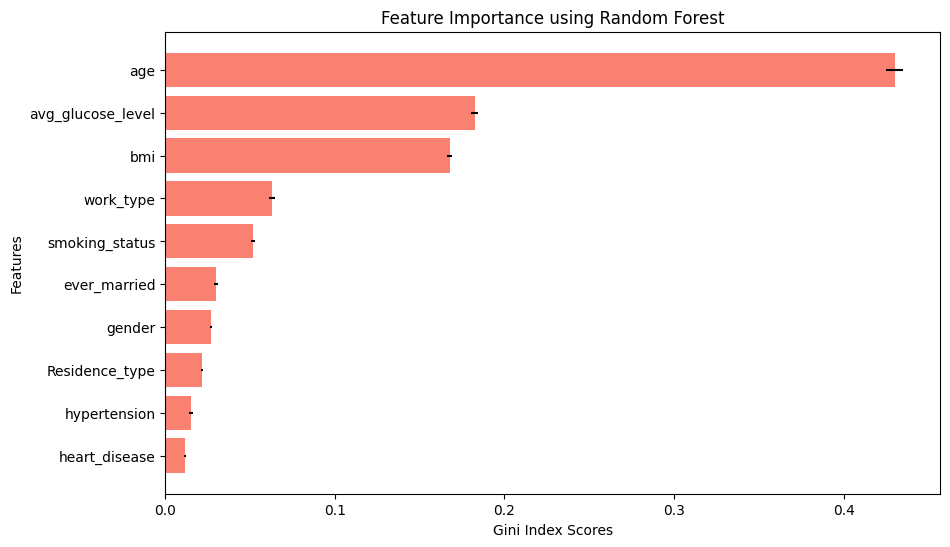

In [ ]:
# FEATURE IMPORTANCE

# Compute mean importance across folds
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Sort features by mean importance
sorted_indices = np.argsort(mean_importances)

# Plot feature importances

plt.figure(figsize=(10, 6))

plt.barh(range(len(sorted_indices)), mean_importances[sorted_indices], xerr=std_importances[sorted_indices] , color='salmon')

plt.yticks(range(len(sorted_indices)), [X_smote.columns[i] for i in sorted_indices])
plt.xlabel("Gini Index Scores")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()

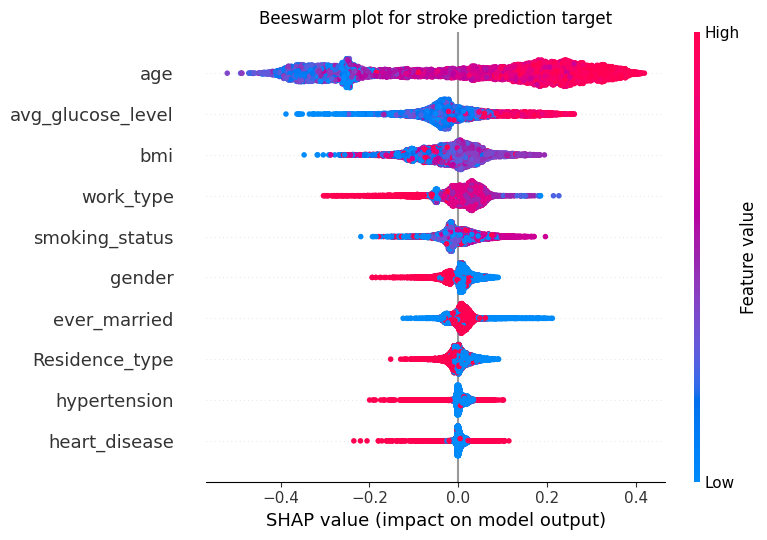

In [ ]:
# GLOBAL EXPLANATION using SHAPLEY VALUES

plt.title('Beeswarm plot for stroke prediction target')

shap.summary_plot(array_shap_1, X_smote.reindex(list_index_test))

In [ ]:
""" {'gender': {'Female': 0, 'Male': 1},
 'work_type_mapping': {'Govt_job': 4, 'Never_worked': 1, 'Private': 3, 'Self-employed': 2, 'children': 0},
 'smoking_status': {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 0, 'smokes': 3},
 'ever_married': {'No': 0, 'Yes': 1},
 'Residence_type': {'Rural': 0, 'Urban': 1}} """

" {'gender': {'Female': 0, 'Male': 1},\n 'work_type_mapping': {'Govt_job': 4, 'Never_worked': 1, 'Private': 3, 'Self-employed': 2, 'children': 0},\n 'smoking_status': {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 0, 'smokes': 3},\n 'ever_married': {'No': 0, 'Yes': 1},\n 'Residence_type': {'Rural': 0, 'Urban': 1}} "

In [ ]:
# CONCLUSION AFTER SUMMARY PLOT

# As you can see, the feature importance obtained with Shapley values is almost the same we have obtained with Gini index.
# Here we can see the incredible power from explainability, we don't have just a list of important features, we can see how those
# values are distributed and which impact the model output the most.

# As expected, age is the most important feature with the higher values that impact the decision-making of the model
# towards the stroke prediction

# For high average glucose level the model tends to predict the patients with stroke and it has a greater impact respect to
# the lower values

# bmi has a strange behaviour because the feature value distribution is not so clear, even though it appears that higher values tend
# the most to impact the stroke prediction

# work_type: higher values correspond to people with full-time jobs and it seems they don't have a great impact with stroke prediction
# differently from other categories

# smoking_status: higher values correspond to people who smoke and it has a distribution as expected

# gender: lower values correspond to Famale people and it seems they have a greater impact to stroke prediction

# residence_type: higher values correspond to Urban and it seems they have a lower impact to stroke prediction

# ever_married: higher values correspond to Yes which has no impact to stroke prediction respect to No option

# hypertension and heart_disease don't show a net distribution with the stroke prediction. Low values (both are equals to patients
# without these diseases) have no impact on model output to predict stroke and high values (people with these diseases) have omogeneus
# distribution on the impact (some of them tends to predict stroke and others tends the model towards no stroke prediction).

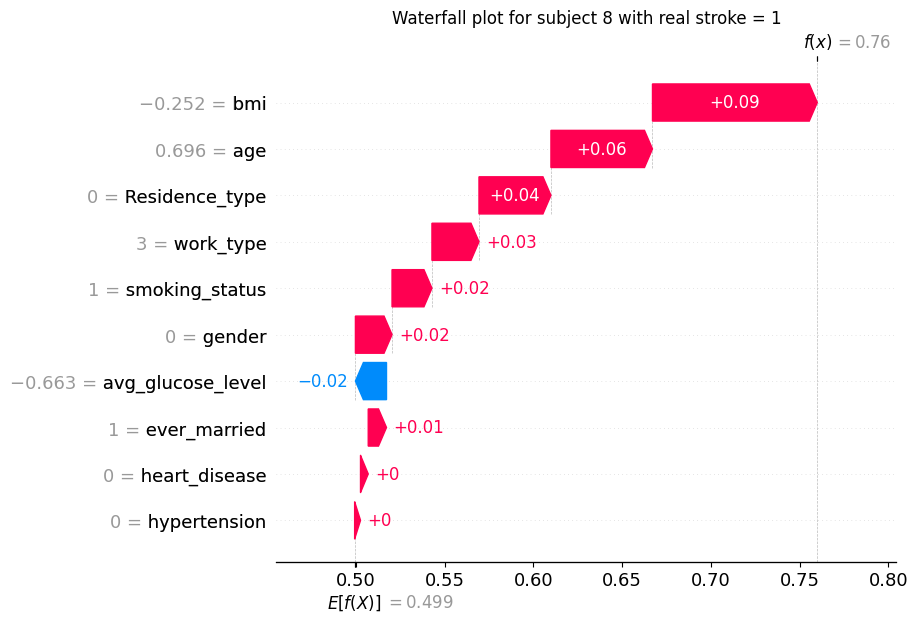

In [ ]:
# LOCAL EXPLANATIONS using SHAPLEY VALUES
# Waterfall Plot

subject = 8

new_index = list_index_test.index(subject)


plt.title(f'Waterfall plot for subject {subject} with real stroke = {y_smote[subject]}')

shap.waterfall_plot(shap.Explanation(values = array_shap_1[new_index],
                                        base_values = array_baseline_1[new_index],
                                        data = X_smote.reindex(list_index_test).iloc[new_index],
                                        feature_names = X_smote.columns.tolist())
                    )


In [ ]:
# CONCLUSION AFTER WATERFALL PLOT

# As you can see the enormous advantage to use the Shapley values is to get a local explanation for each subject about the feature
# importance; which features impact the most to predict correctly the istance in order to increase the eXplainability for a ML model.

# For the subject 8, age is at the 2-nd importance place to predict correctly its stroke value, differently form the global importance
# in which age always appears at the 1-st place. In this way, we can understand how ML model behaves differently acccording to the
# subject it analyzes.

## Shapley values with Iterated 10-folds CV

In [ ]:
# Perform iterated 10-fold stratified cross-validation for each model (WITH ITERATIONS)
# This will allow us to obtain more stable results, even though they could not change respect the previous ones.

# DF to save results
results_test_iter = pd.DataFrame()
results_test = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 5

# Define dict for each metric for both test predictions
test_metrics = {
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1 Score' : [],
    'AUC' : []
}

# Define dict for shapley values and baselines for each class
shap_values_1_per_cv = dict()
shap_values_0_per_cv = dict()
baselines_1_per_cv = dict()
baselines_0_per_cv = dict()

for subject in X_smote.index:
    # Create keys for each subject
    shap_values_1_per_cv[subject] = {}
    shap_values_0_per_cv[subject] = {}
    baselines_1_per_cv[subject] = {}
    baselines_0_per_cv[subject] = {}
    # Create keys for each CV fold within each subject
    for cv_iteration in range(num_iter):
        shap_values_1_per_cv[subject][cv_iteration] = {}
        shap_values_0_per_cv[subject][cv_iteration] = {}
        baselines_1_per_cv[subject][cv_iteration] = {}
        baselines_0_per_cv[subject][cv_iteration] = {}

# Define model
model = RandomForestClassifier(random_state=59)
name = "Random Forest"

for i in range(0,num_iter):

    print(f'Iteration {i+1}...')

    # Set up stratified CV
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)

    for j, (train_index, test_index) in enumerate(stratified_cv.split(X_smote, y_smote)):

        print(f'Split {j+1}...')

        X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
        y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)

        # predictions
        y_pred_fold = model.predict(X_test_fold)

        # Define explainer for SHAP
        explainer = shap.Explainer(model)

        # shapley values and baseline values for X_test_fold
        shap_values = explainer(X_test_fold).values
        baselines = explainer(X_test_fold).base_values

        # Insert shapley values and baseline values for each subject in X_test_fold for each stroke class [0,1]
        for k, test_idx in enumerate(test_index):
            shap_values_1_per_cv[test_idx][i] = shap_values[:,:,1][k]
            shap_values_0_per_cv[test_idx][i] = shap_values[:,:,0][k]
            baselines_1_per_cv[test_idx][i] = baselines[:,1][k]
            baselines_0_per_cv[test_idx][i] = baselines[:,0][k]

        # metrics calculation for test
        test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
        test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
        test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
        test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))

# Collecting metric values for eahc iteration for each model (both train and test)
metric_test_iter = {
    metric : value for metric, value in test_metrics.items()
}
cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)


# Collecting mean and std values for each metric and for each model (both train and test)
mean_folds_metrics = {
    metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
}
cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])
res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
results_test = pd.concat([results_test, res_test_medium], axis=1)

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_test_iter.index = metric_test_iter.keys()

Iteration 1...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 2...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 3...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 4...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...
Iteration 5...
Split 1...
Split 2...
Split 3...
Split 4...
Split 5...
Split 6...
Split 7...
Split 8...
Split 9...
Split 10...


In [ ]:
# AVERAGE SHAPLEY VALUES FOR EACH ITERATION

# Establish lists to keep average Shap values, their Stds, and their min and max (optionals) for each stroke class [0,1]
average_shap_values_1, stds_s_1, ranges_s_1 = [],[],[]
average_shap_values_0, stds_s_0, ranges_s_0 = [],[],[]
average_baselines_1, stds_b_1, ranges_b_1 = [],[],[]
average_baselines_0, stds_b_0, ranges_b_0 = [],[],[]

for i in range(0,len(X_smote)):
    # Get relevant statistics for every sample
    # Shapley values class 1
    average_shap_values_1.append(pd.DataFrame.from_dict(shap_values_1_per_cv[i]).mean(axis=1).values)
    stds_s_1.append(pd.DataFrame.from_dict(shap_values_1_per_cv[i]).std(axis=1).values)
    ranges_s_1.append(pd.DataFrame.from_dict(shap_values_1_per_cv[i]).max(axis=1).values-pd.DataFrame.from_dict(shap_values_1_per_cv[i]).min(axis=1).values)

    # Shapley values class 0
    average_shap_values_0.append(pd.DataFrame.from_dict(shap_values_0_per_cv[i]).mean(axis=1).values)
    stds_s_0.append(pd.DataFrame.from_dict(shap_values_0_per_cv[i]).std(axis=1).values)
    ranges_s_0.append(pd.DataFrame.from_dict(shap_values_0_per_cv[i]).max(axis=1).values-pd.DataFrame.from_dict(shap_values_0_per_cv[i]).min(axis=1).values)

    # baselines class 1
    average_baselines_1.append(pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).mean(axis=0).values)
    stds_b_1.append(pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).std(axis=0).values)
    ranges_b_1.append(pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).max(axis=0).values-pd.DataFrame.from_dict(baselines_1_per_cv[i].values()).min(axis=0).values)

    # baselines class 0
    average_baselines_0.append(pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).mean(axis=0).values)
    stds_b_0.append(pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).std(axis=0).values)
    ranges_b_0.append(pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).max(axis=0).values-pd.DataFrame.from_dict(baselines_0_per_cv[i].values()).min(axis=0).values)

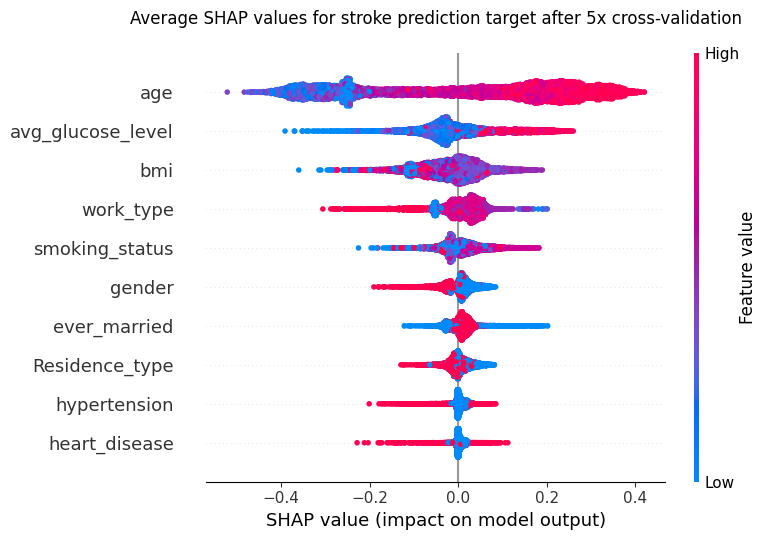

In [ ]:
# GLOBAL INFORMATION
# As you can see the order of feature importance is not changed, but now the results are more robust

plt.title('Average SHAP values for stroke prediction target after 5x cross-validation\n')

shap.summary_plot(np.array(average_shap_values_1), X_smote, show = False)

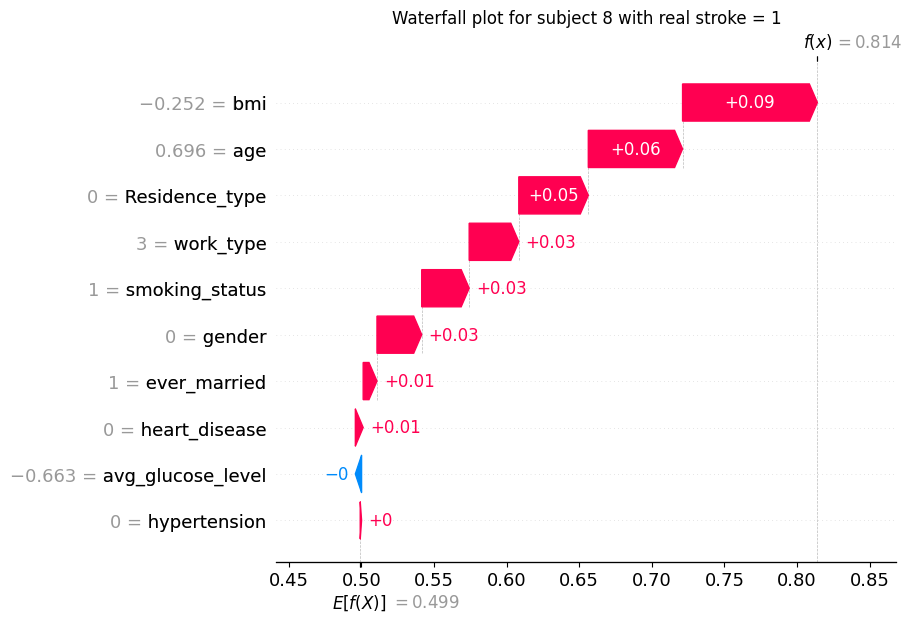

In [ ]:
# LOCAL EXPLANATIONS
# Waterfall Plot

# Here you can see some differences, average glucose level is a the bottom of this calssify and some features have slightly changed
# their positions respect to the previous we got with waterfall plot without iterated CV

subject = 8


plt.title(f'Waterfall plot for subject {subject} with real stroke = {y_smote[subject]}')

shap.waterfall_plot(shap.Explanation(values = average_shap_values_1[subject],
                                        base_values = average_baselines_1[subject],
                                        data = X_smote.iloc[subject],
                                        feature_names = X_smote.columns.tolist())
                    )

## APPENDIX

In [ ]:
# THIS SUBSECTION TO SHOW OTHER POSSIBLE PLOT IT IS POSSIBLE TO OBTAIN USING SHAPLEY VALUES

# Recreate an EXPLAINER using average Shapley and baseline values for class stroke = 1

explainar_post = shap.Explanation(values = np.array(average_shap_values_1),
                                        base_values = np.array(average_baselines_1),
                                        data = np.array(X_smote),
                                        feature_names = np.array(X_smote.columns.tolist()))

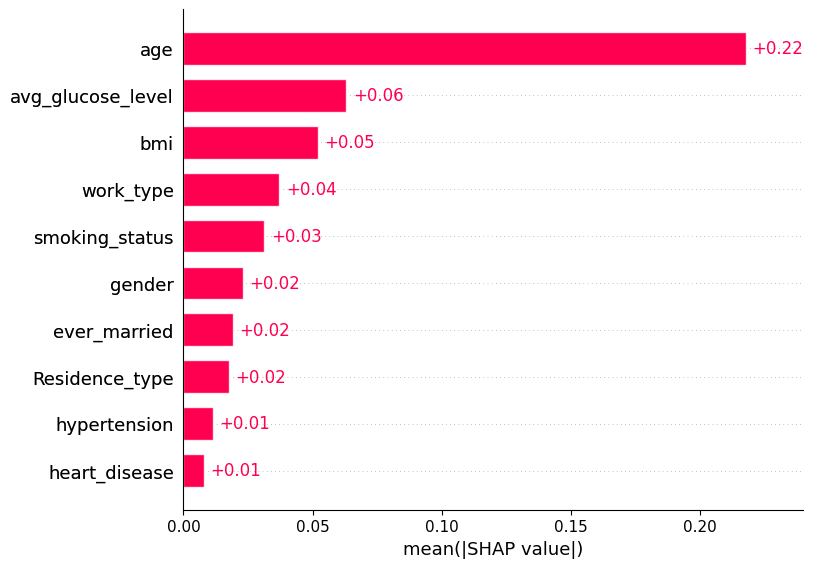

In [ ]:
# Bar plot using Shaply values

shap.plots.bar(explainar_post)

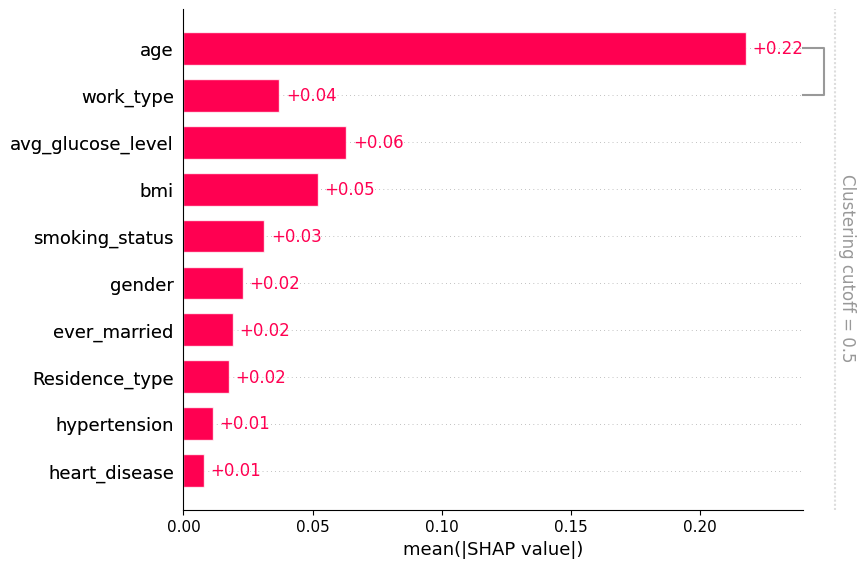

In [ ]:
# CLUSTERING using SHAPLEY VALUES
# Shap feature clustering highlights highly correlated variables.

# You can see that age and work_type seem to be highly correlated but using a cut-off e quals to 0.5

shap_clustering = shap.utils.hclust(X_smote, y_smote)
shap.plots.bar(explainar_post, clustering=shap_clustering, clustering_cutoff=0.5)

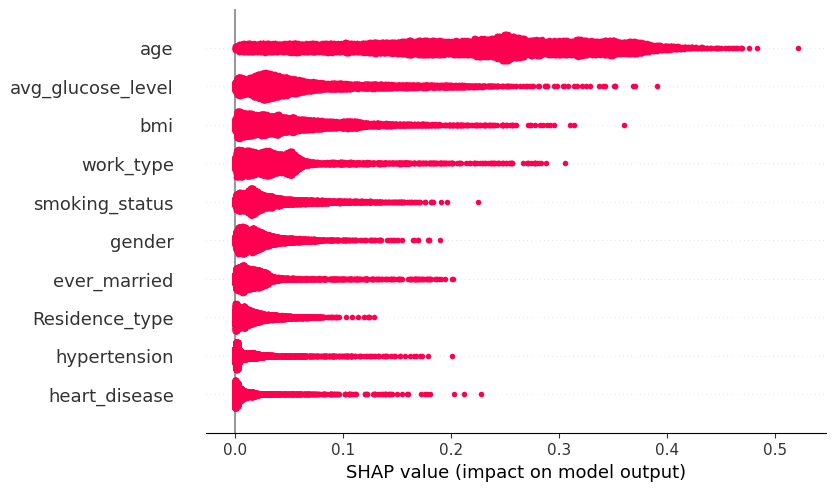

In [ ]:
# Beeswarm plot as bar plot using abs Shapley values

shap.plots.beeswarm(explainar_post.abs, color="shap_red")

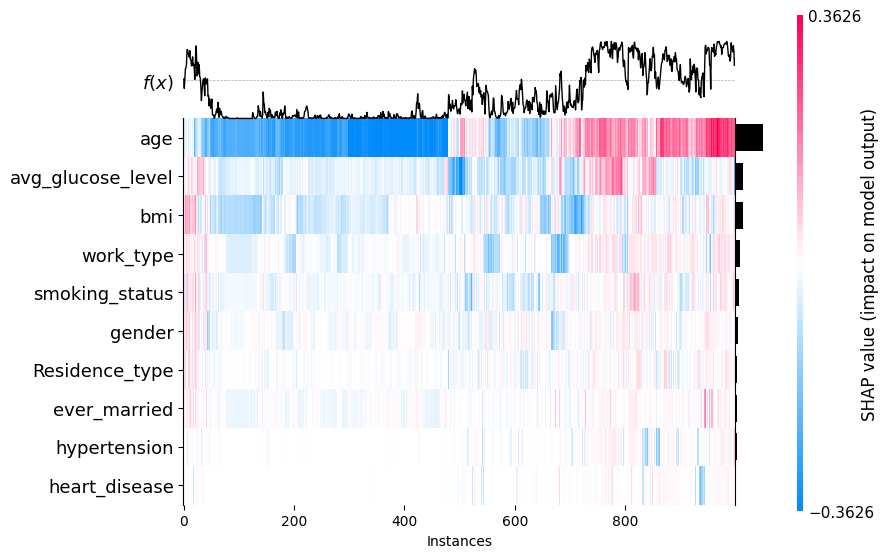

In [ ]:
# Heatmap of Shapley values for the first 1000 istances

shap.plots.heatmap(explainar_post[:1000])

In [ ]:
# In order to visualize a scatter plot, I create a new explanation object without base values (we don't need them)

explainar_post_2 = shap.Explanation(values = np.array(average_shap_values_1),
                                        data = np.array(X_smote),
                                        feature_names = np.array(X_smote.columns.tolist()))

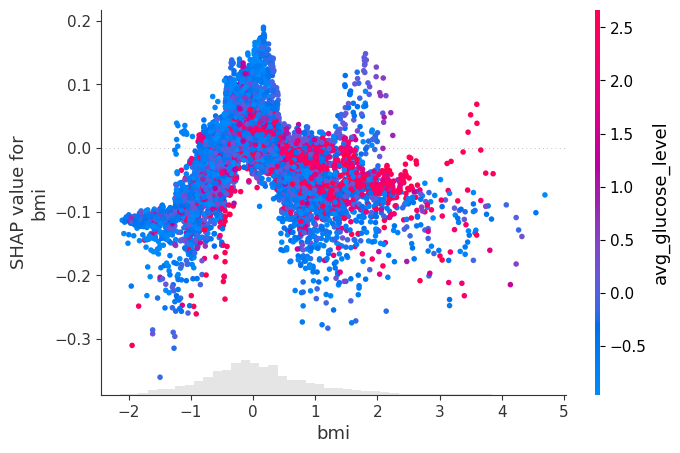

In [ ]:
# Scatter Plot

shap.plots.scatter(explainar_post_2[:,'bmi'], color = explainar_post_2)

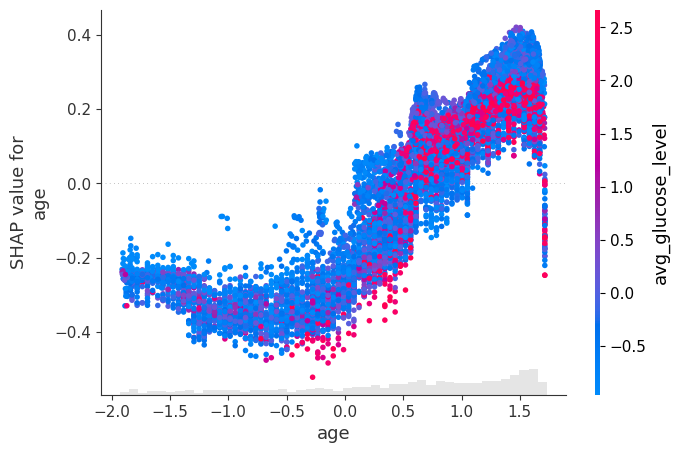

In [ ]:
# Scatter Plot

shap.plots.scatter(explainar_post_2[:,'age'], color = explainar_post_2)

In [ ]:
# Force Plot for one observation

shap.initjs()

force_plot = shap.plots.force(explainar_post[8])

# To get a white background with dark-mode
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")